In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from kp.utils.constants import EXPERIMENTS_DIR
from kp.plotting.plotting import find_results_files, organize_results, plot_metric

In [3]:
base_experiments_dir = EXPERIMENTS_DIR

In [4]:
allow_smoke_test = False
all_my_results_files = find_results_files(base_experiments_dir, allow_smoke_test)

Searching for 'results.json' files in: /net/projects/clab/tnief/bidirectional-reversal/experiments
Found 128 'results.json' files.


In [5]:
all_my_results_files

[PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/lm_head_last_token/fake_movies_real_actors/gpt2-xl/sft2pre/no_patching/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-11_19-32-59/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/lm_head_last_token/fake_movies_real_actors/gpt2-xl/sft2pre/fe_lt/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-11_19-32-59/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/lm_head_last_token/fake_movies_real_actors/gpt2-xl/sft2pre/lt/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-11_19-32-59/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/lm_head_last_token/fake_movies_real_actors/gpt2-xl/sft2pre/not_lt/all_2025-05-07_21-56-24_best_saved_checkpoint_2025-05-11_19-32-59/sentence_1/dropout_0.0_layer_co

In [6]:
organized_results = organize_results(all_my_results_files, base_experiments_dir)

Attempted to parse paths for 128 files.
Successfully parsed path metadata for 128 files.
Successfully calculated metrics for 128 files.
Organized data into 1 datasets.
  Dataset 'fake_movies_real_actors' has 2 model configurations.


In [7]:
organized_results['fake_movies_real_actors']

defaultdict(<function kp.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>()>,
            {'lm_head_last_token': defaultdict(<function kp.plotting.plotting.organize_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                         {'gpt2-xl': defaultdict(dict,
                                      {'sentence_1': {'no_patching_sft2pre': {'mean_target_rank': 584.1201201201201,
                                         'top_k_accuracy': 0.012012012012012012,
                                         'mean_target_prob': 0.0015480238312239908},
                                        'fe_lt': {'mean_target_rank': 1.1851851851851851,
                                         'top_k_accuracy': 0.997997997997998,
                                         'mean_target_prob': 0.9642855081703685},
                                        'lt': {'mean_target_rank': 118.58258258258259,
                                         'top_k_accuracy': 0.12012012012

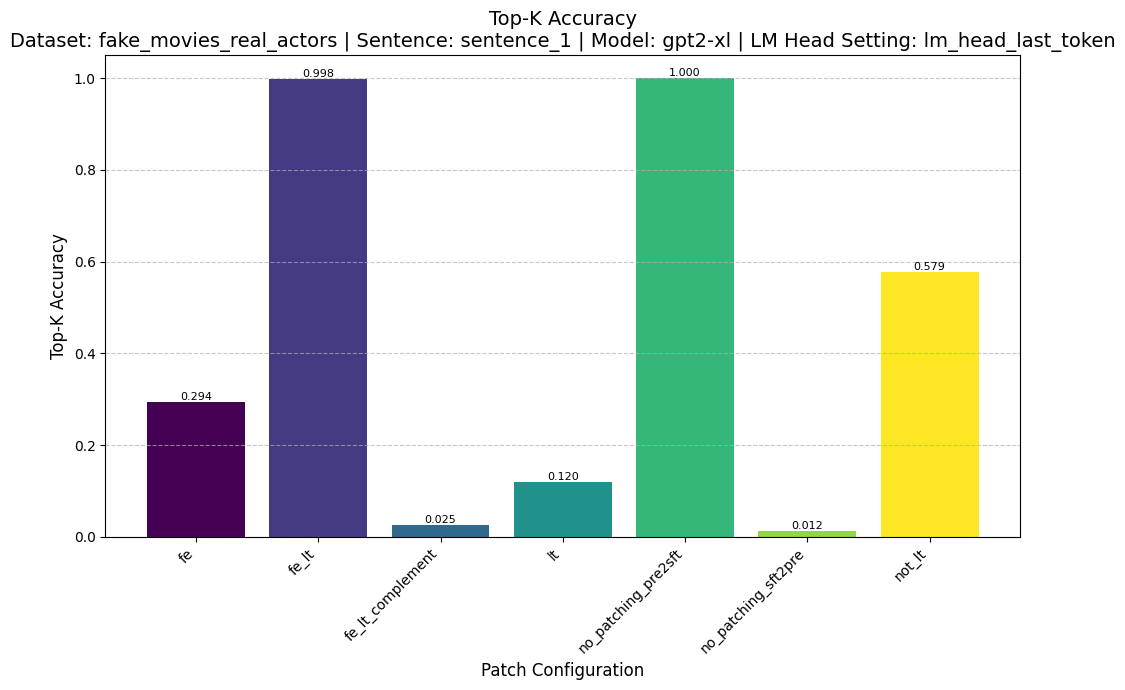

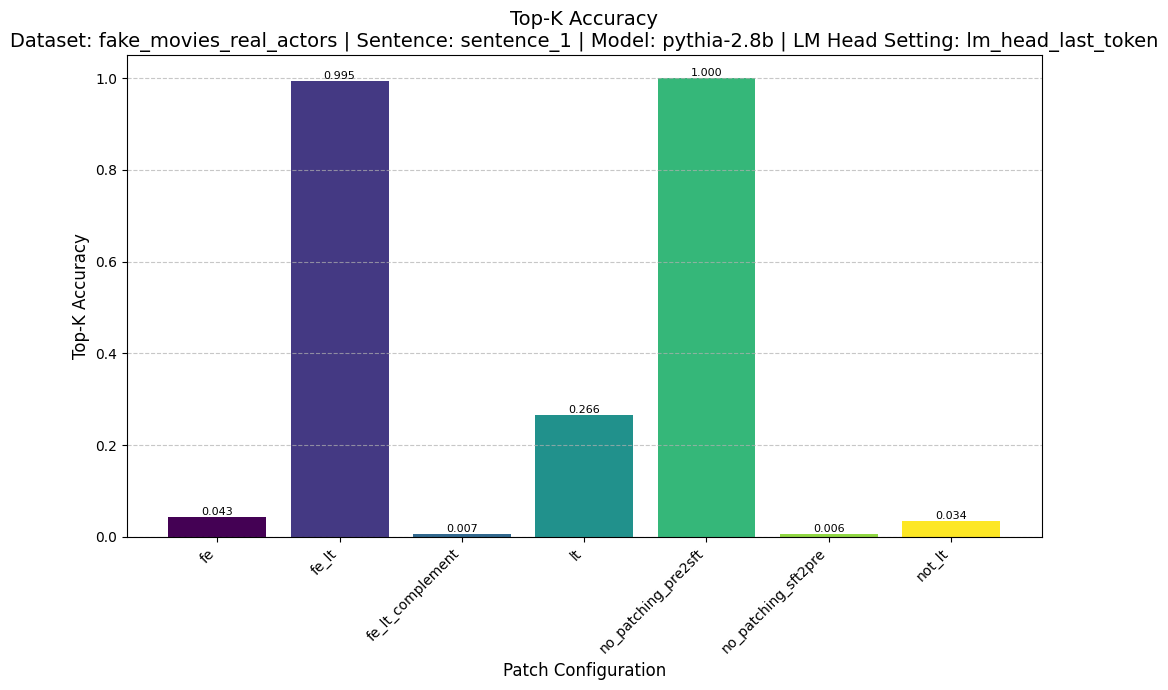

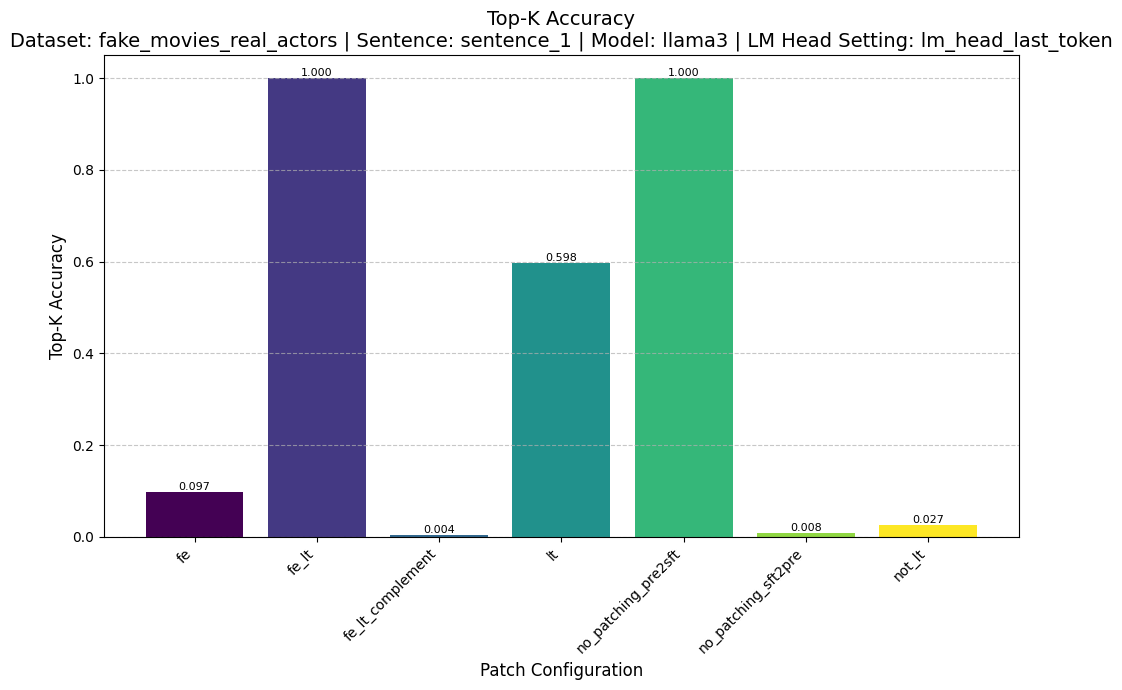

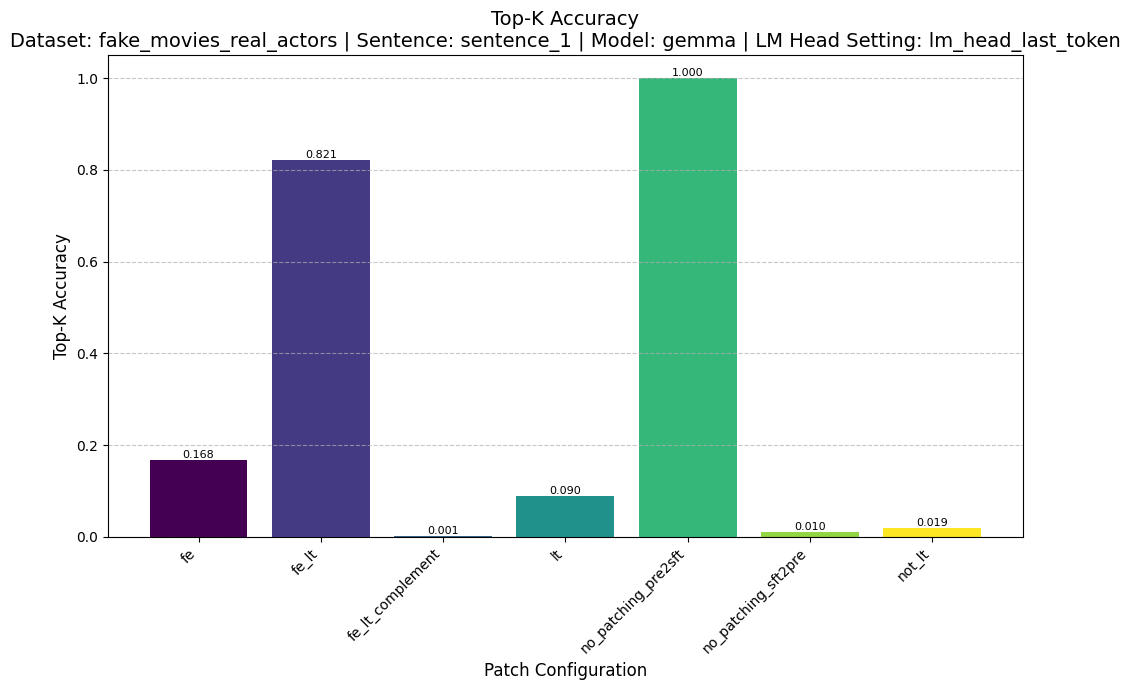

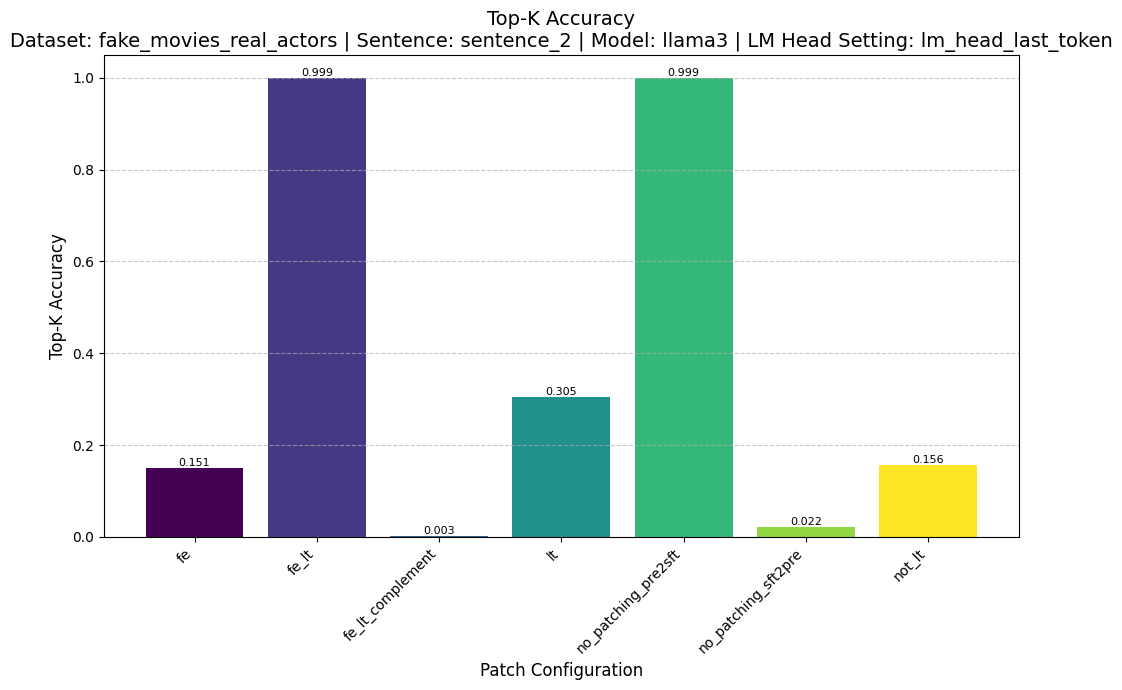

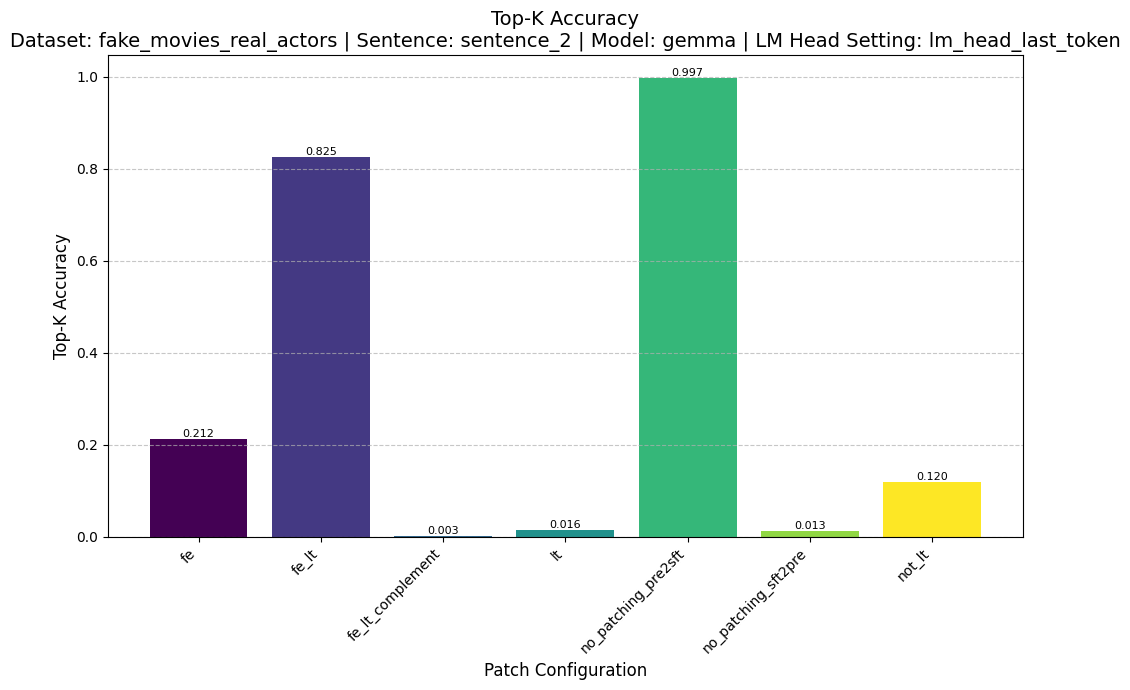

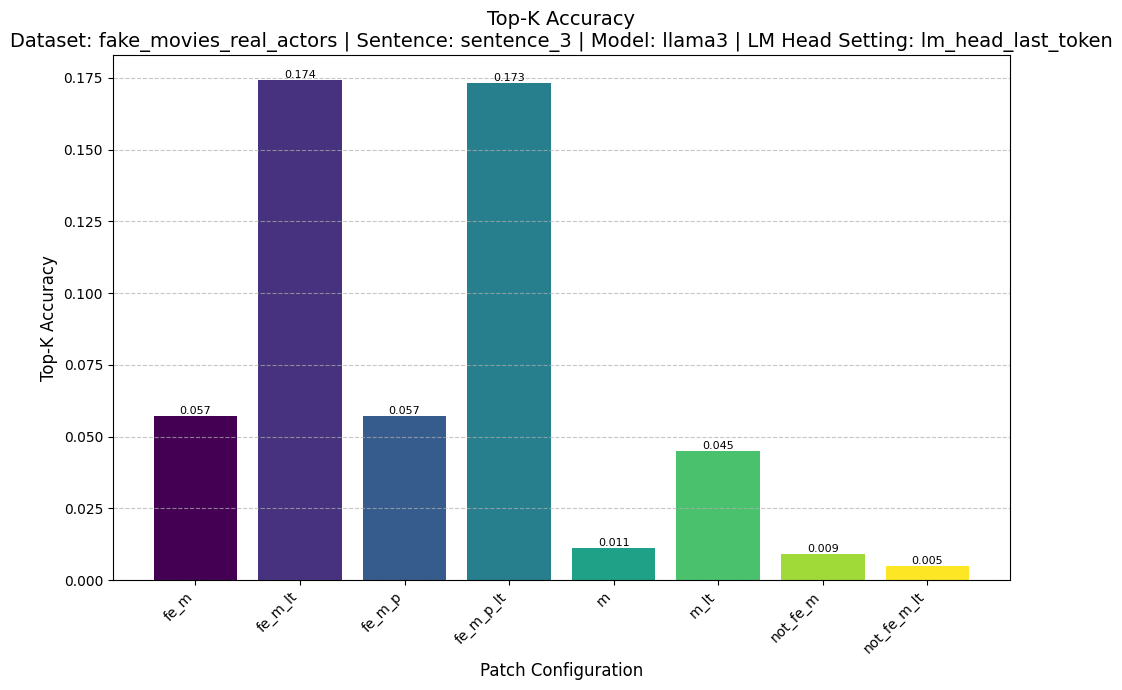

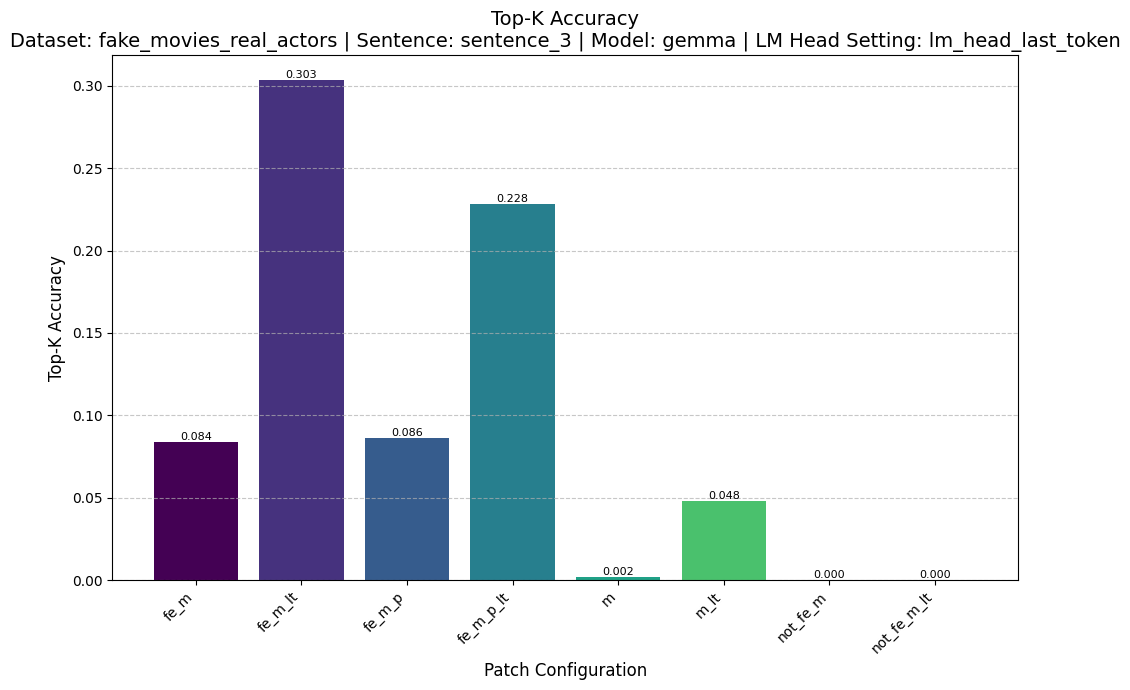

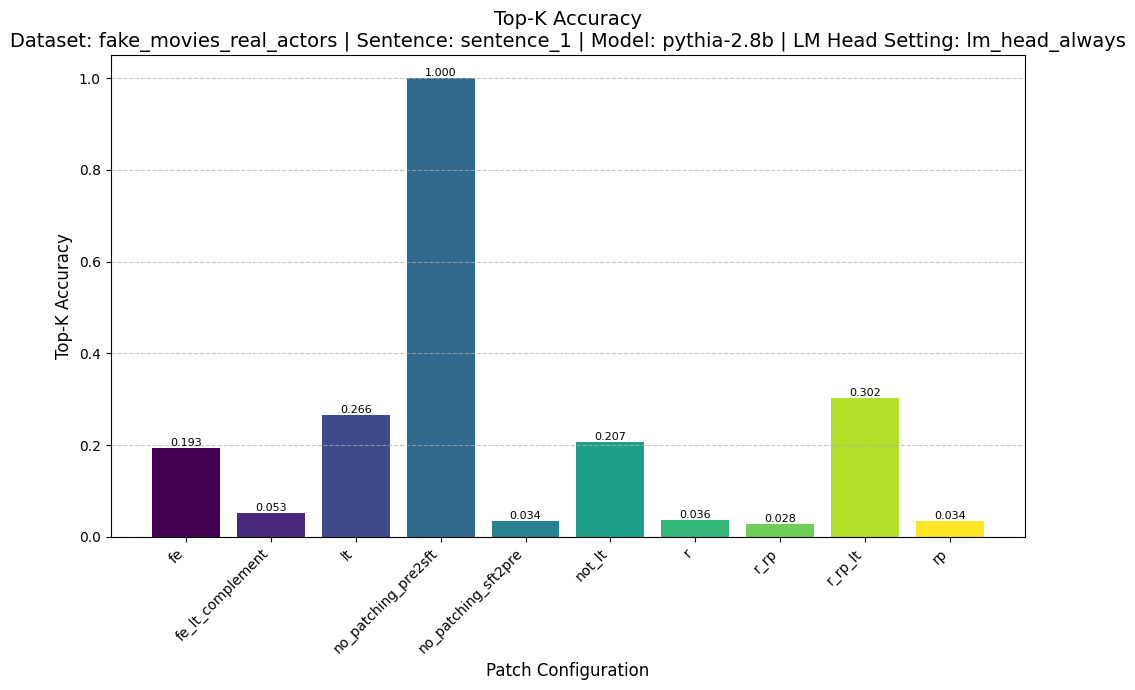

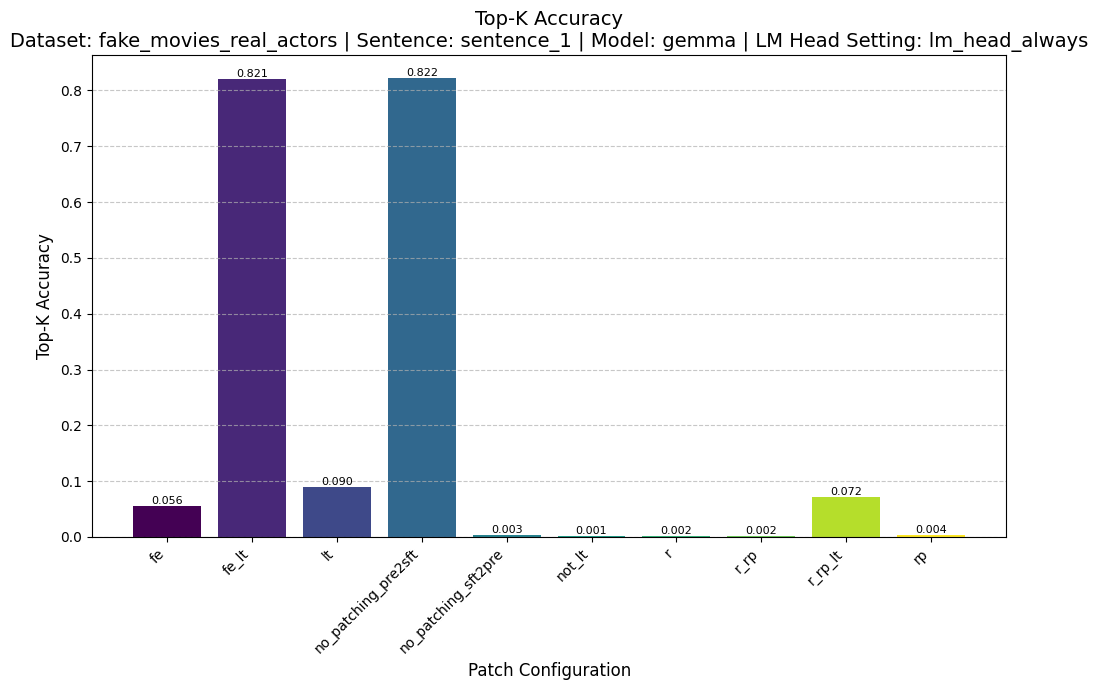

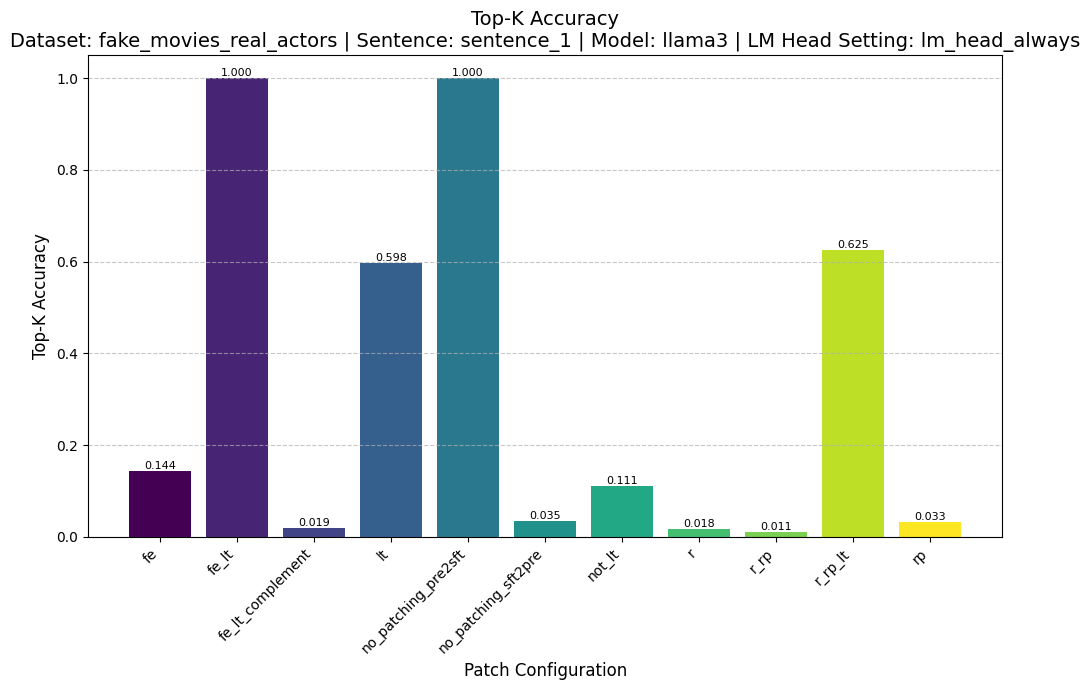

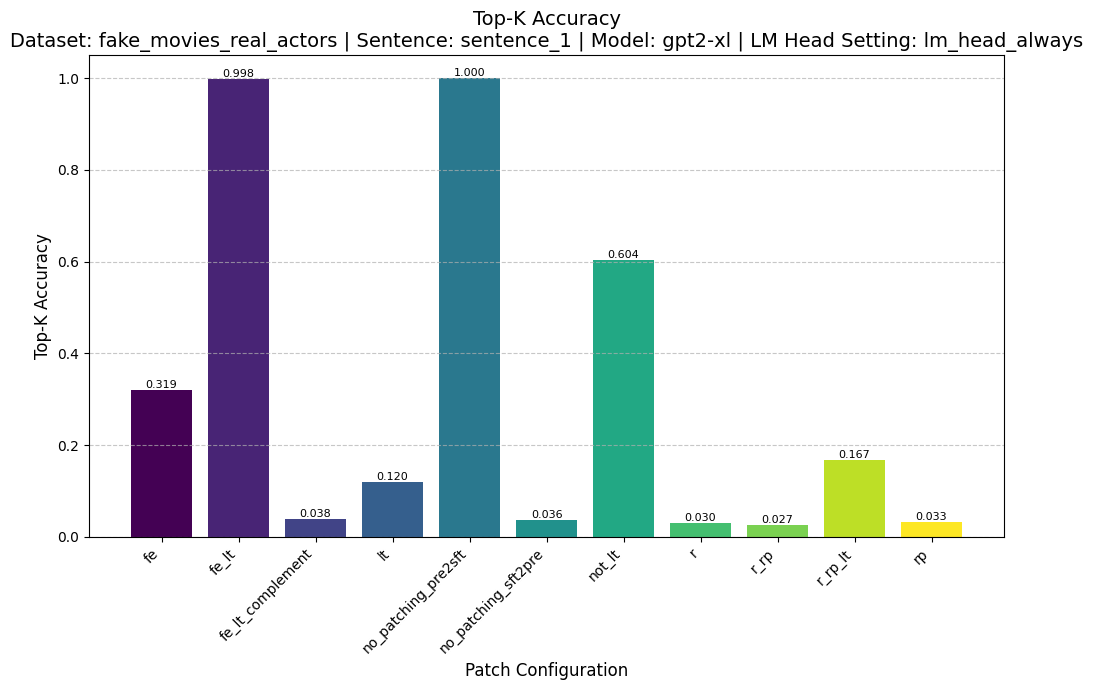

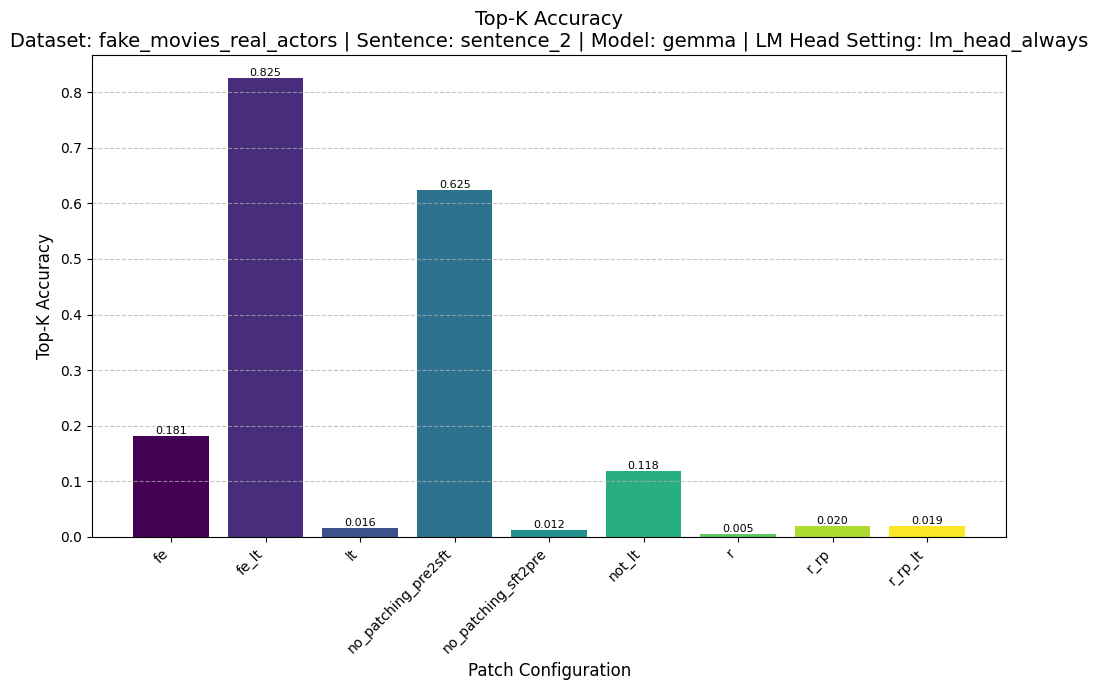

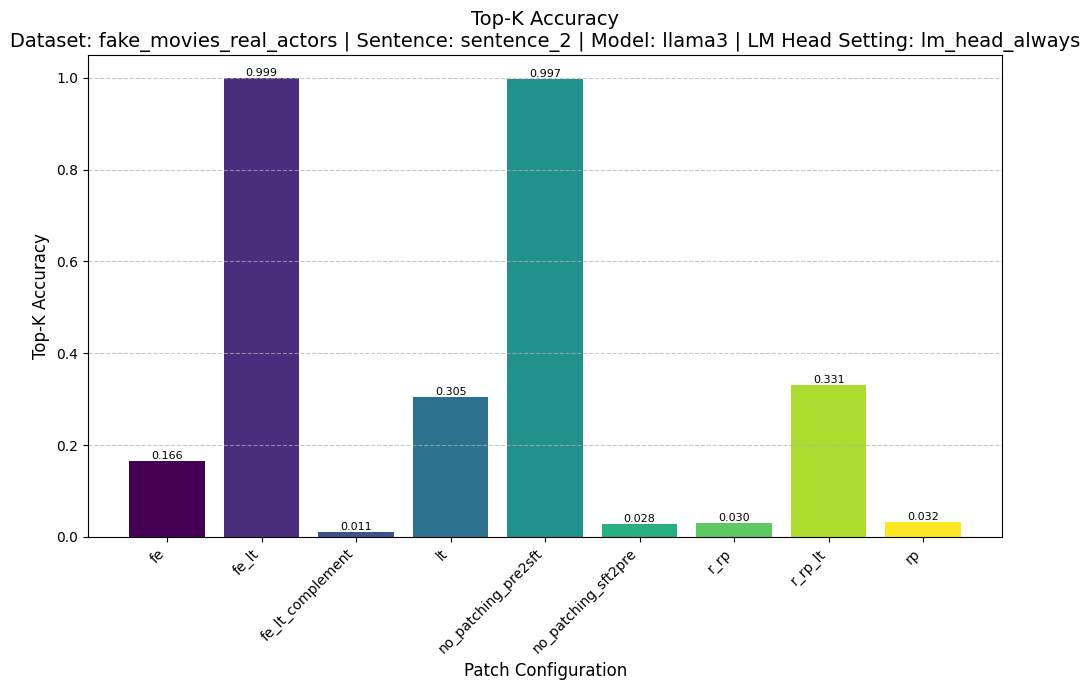

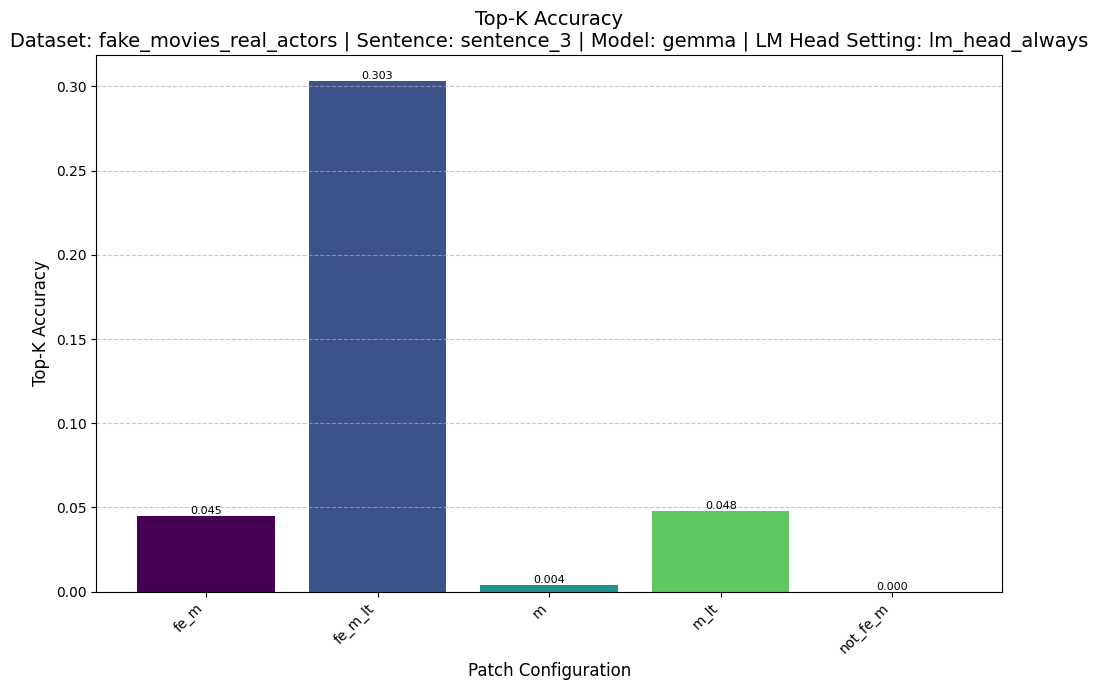

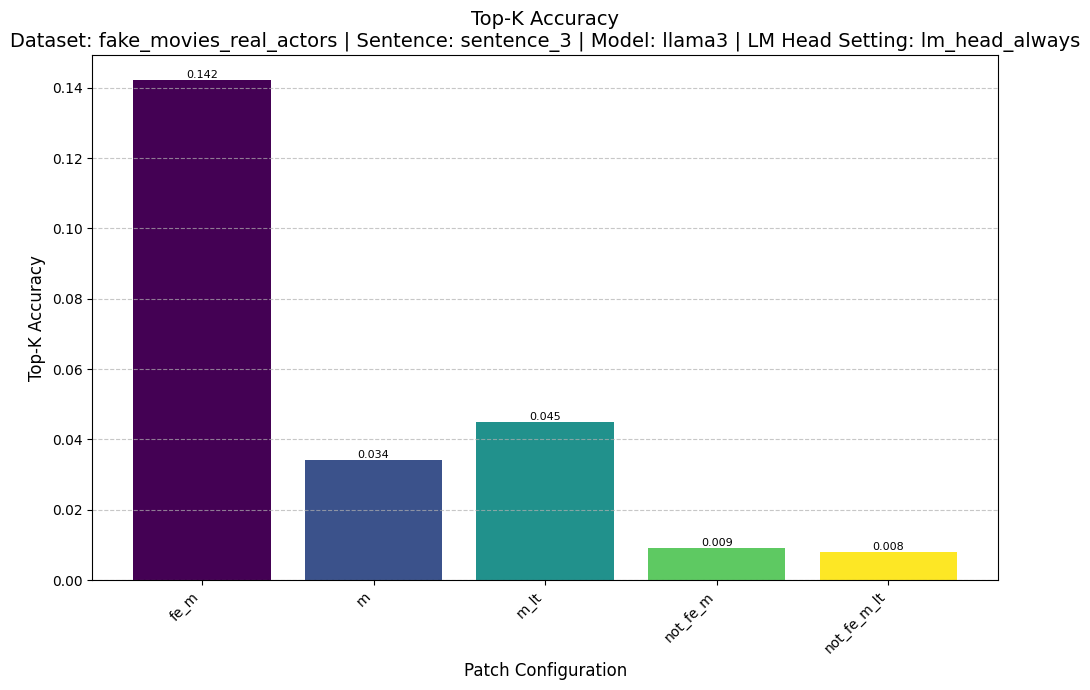

In [8]:
metric_key = "top_k_accuracy"
plot_metric(organized_results, metric_key)

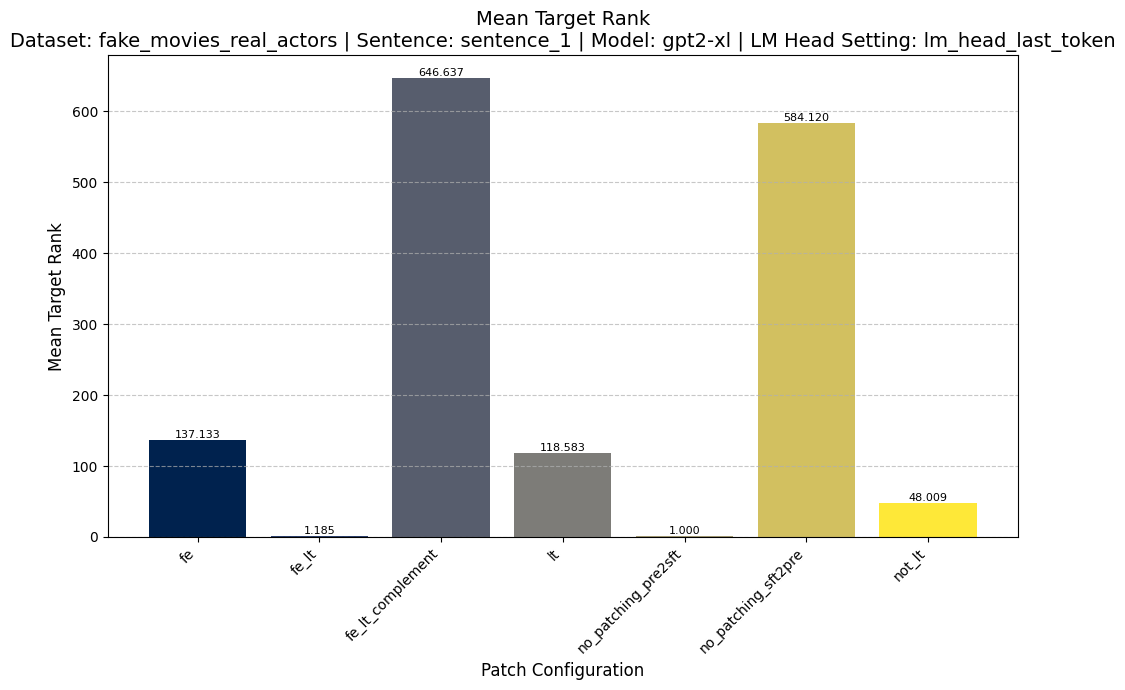

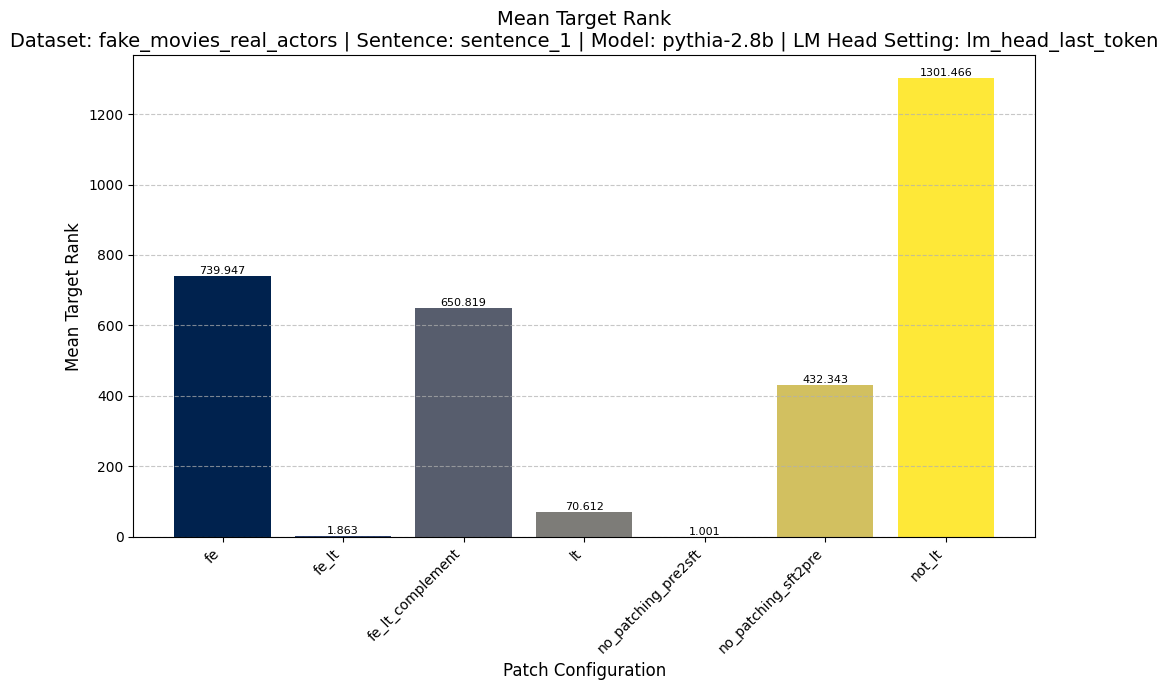

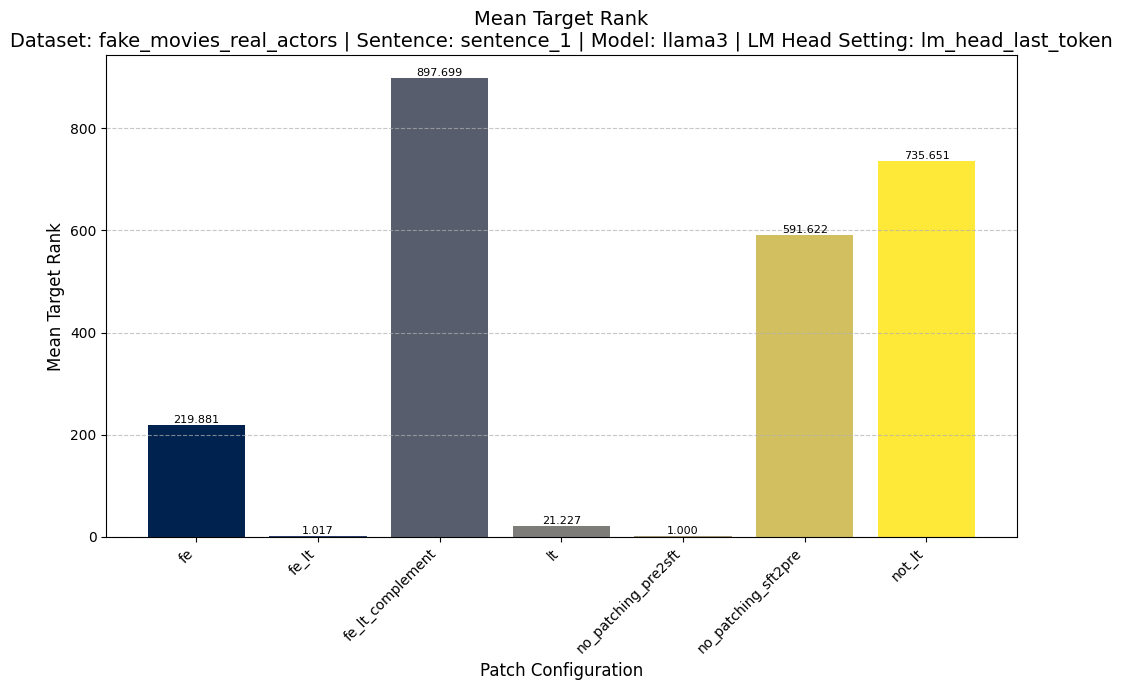

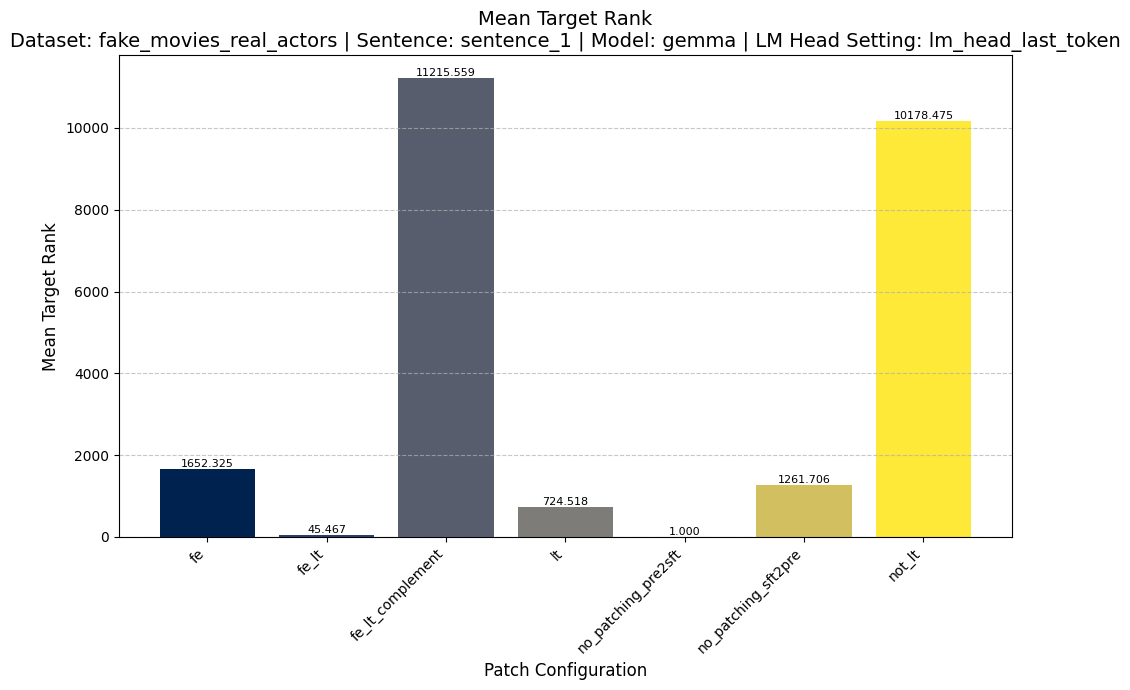

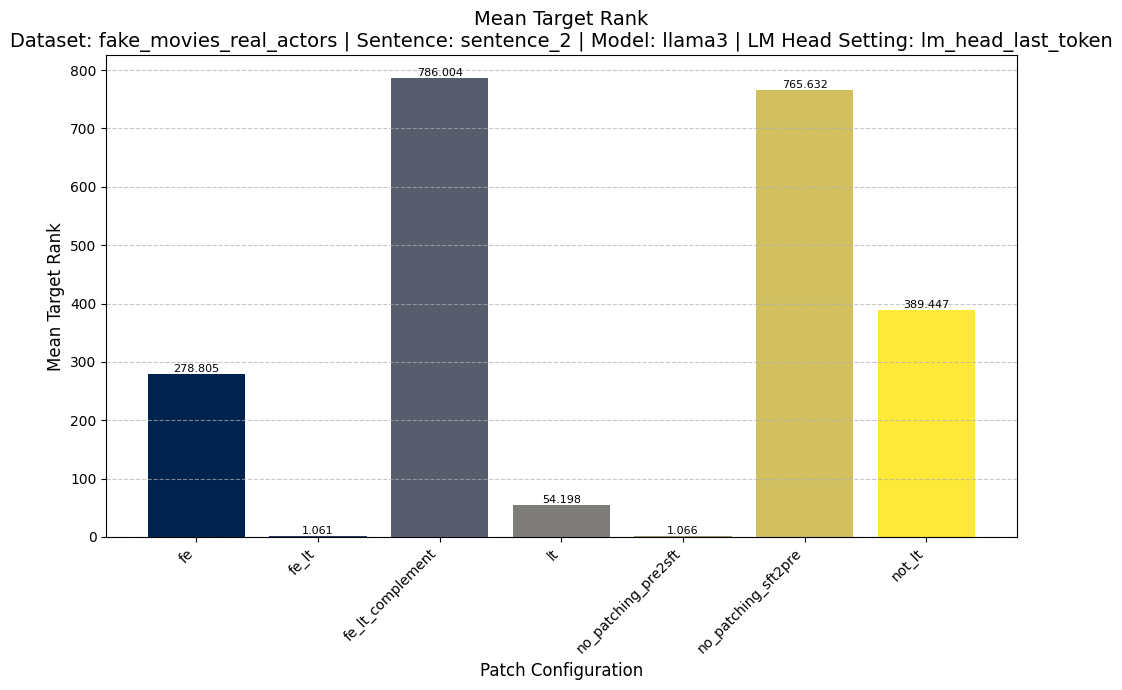

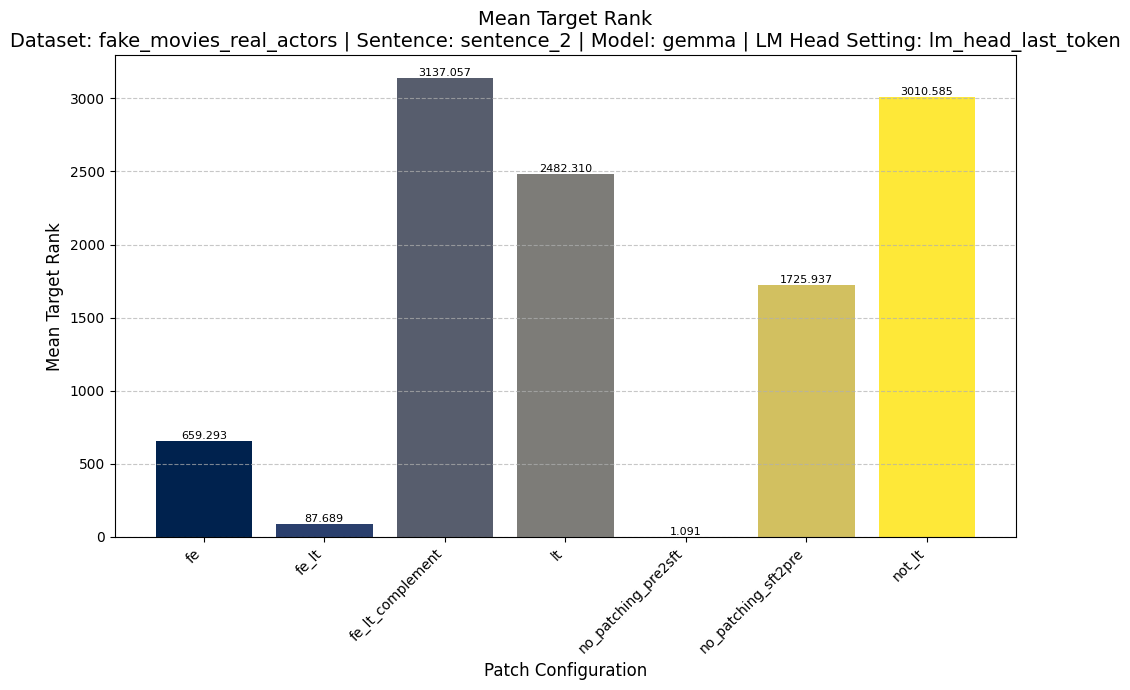

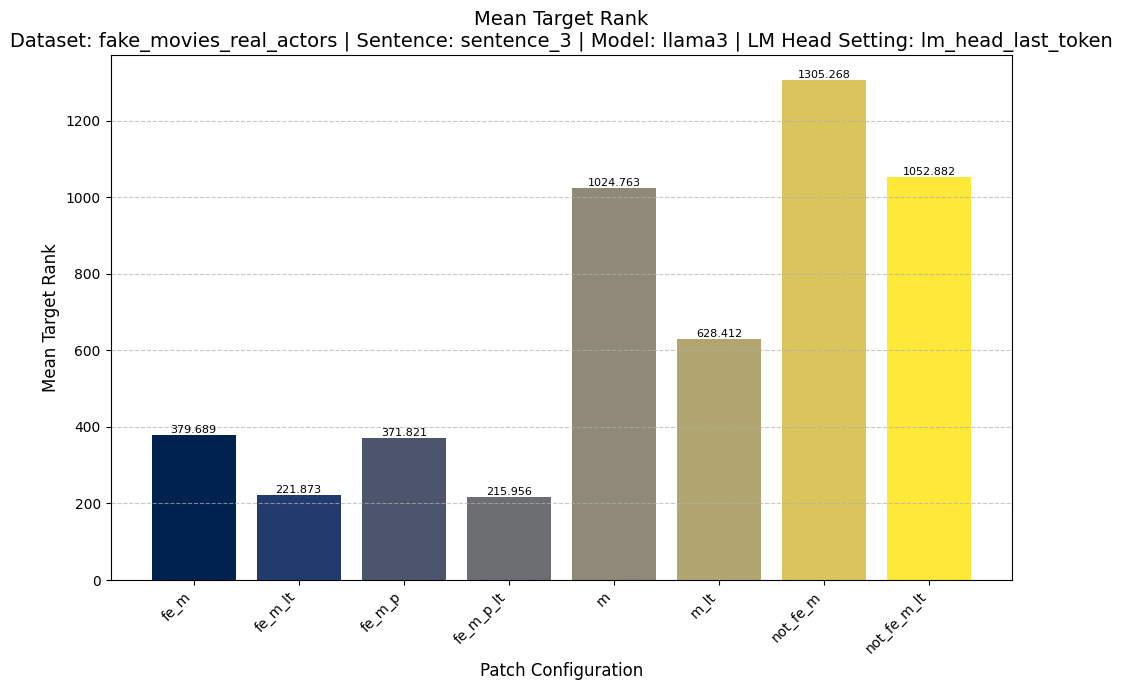

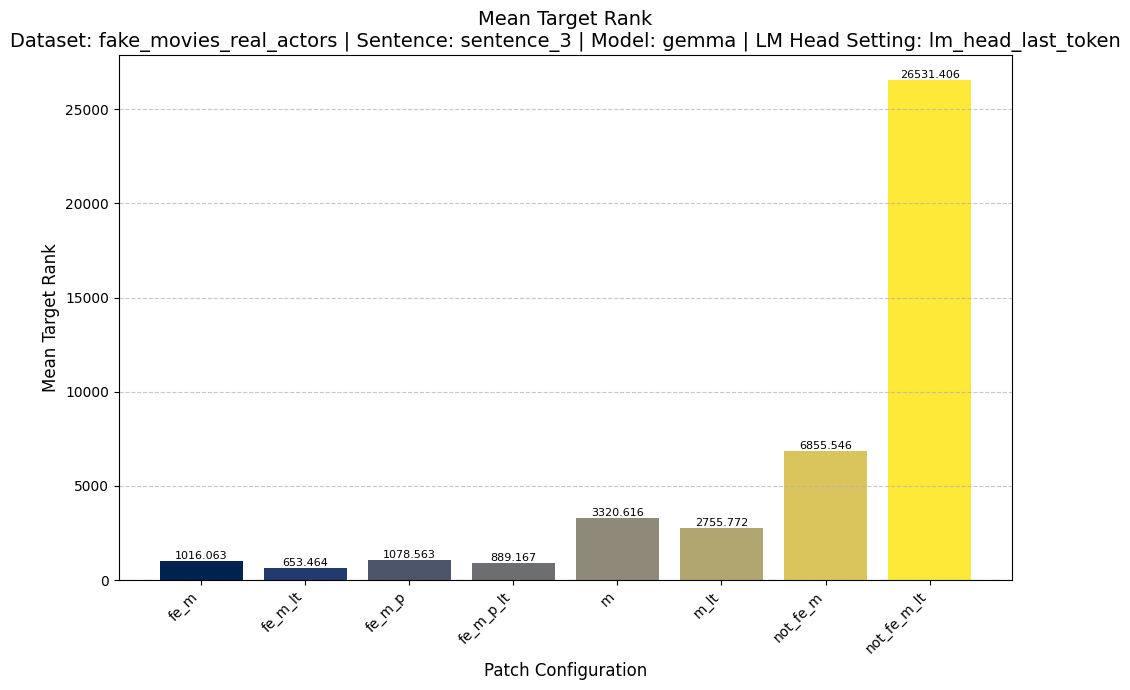

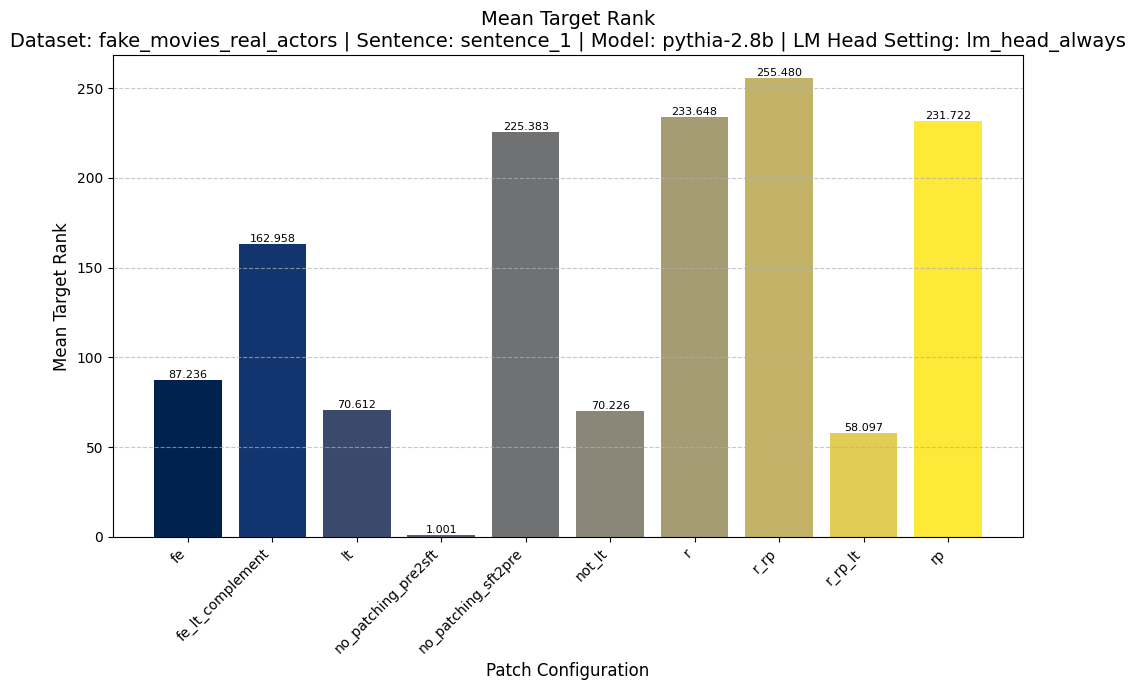

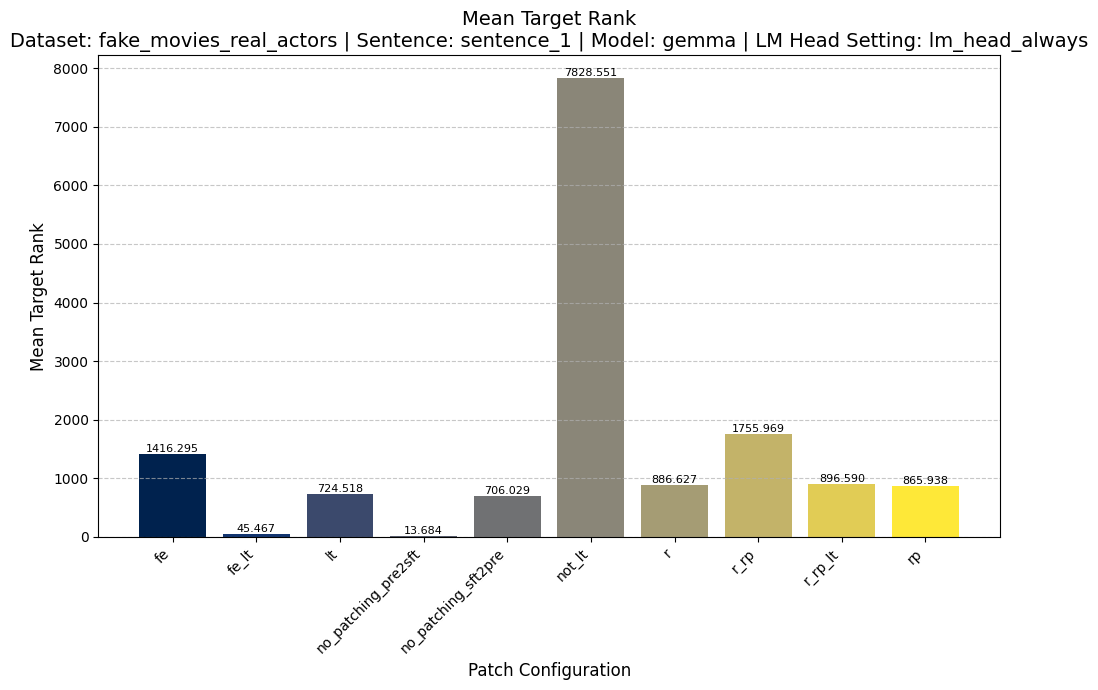

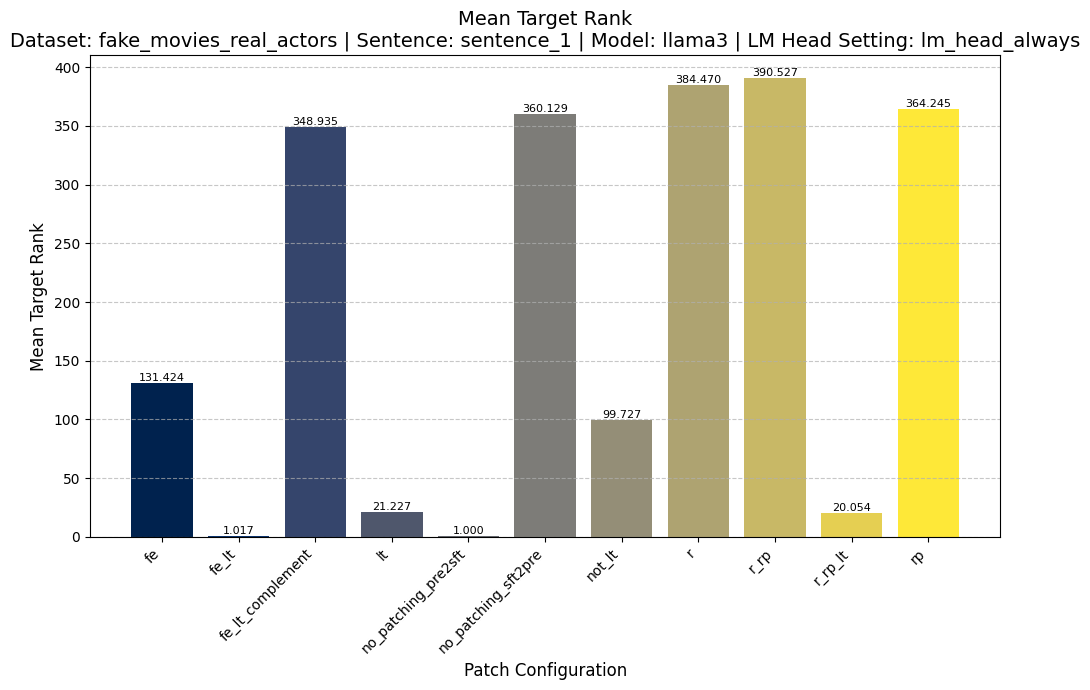

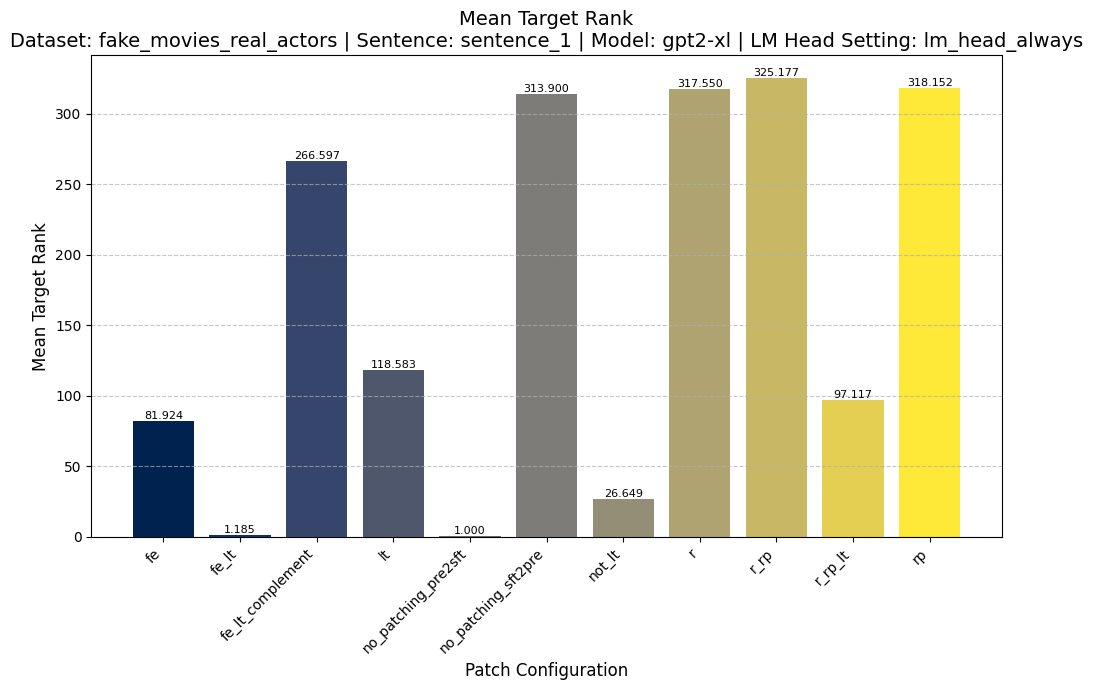

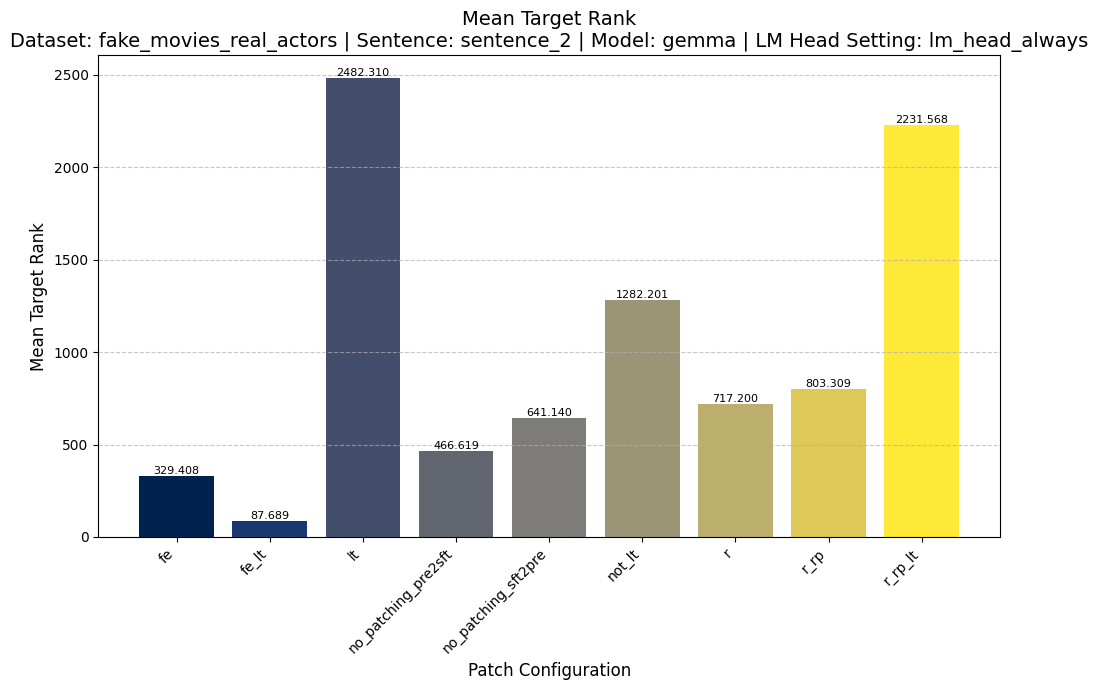

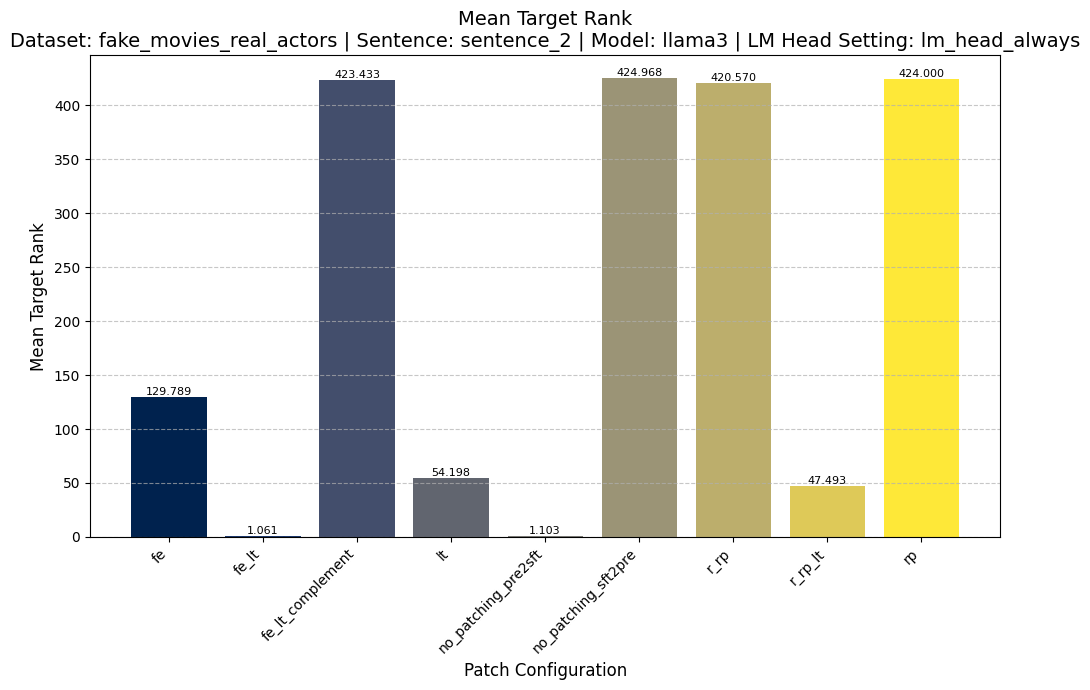

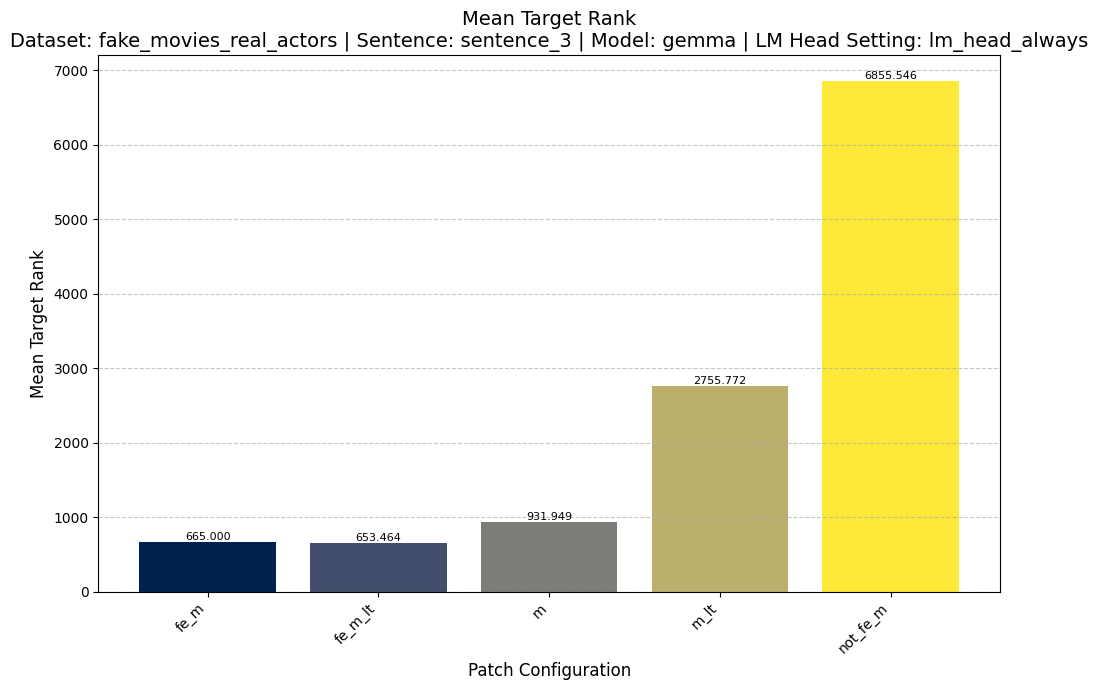

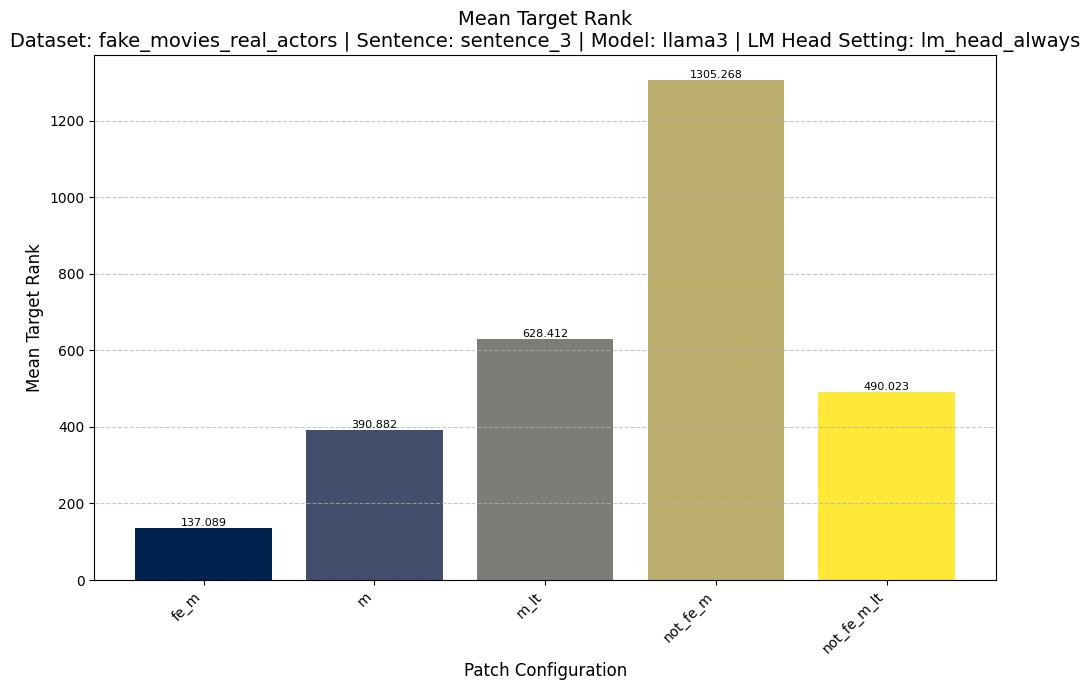

In [9]:
metric_key = "mean_target_rank"
plot_metric(organized_results, metric_key)

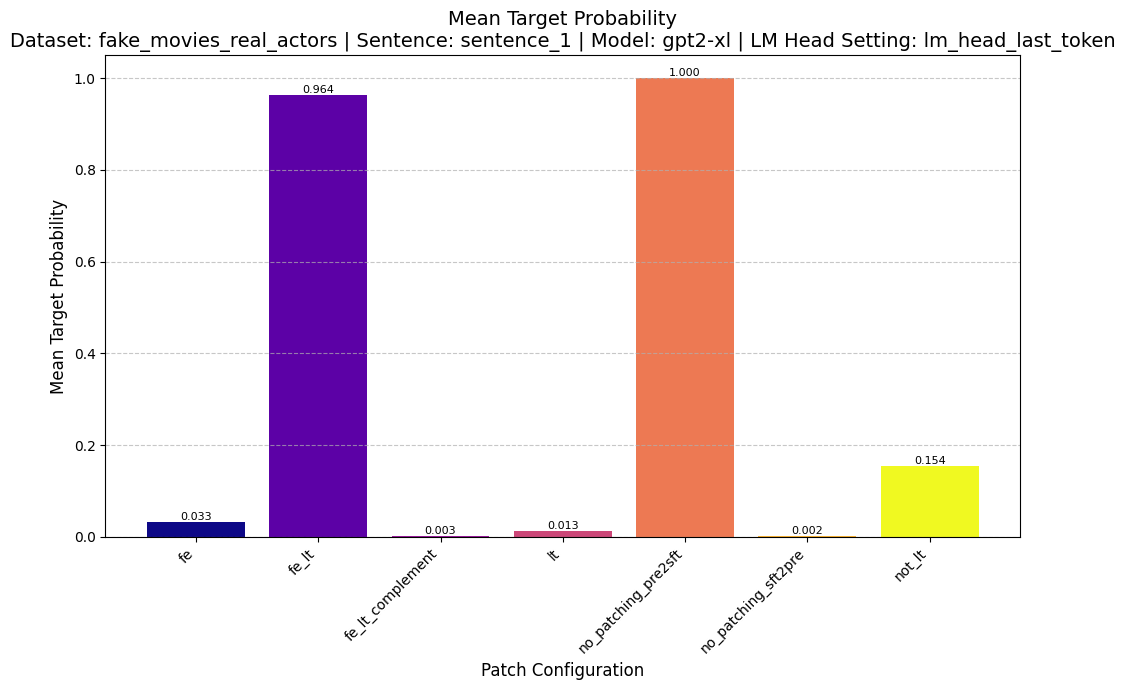

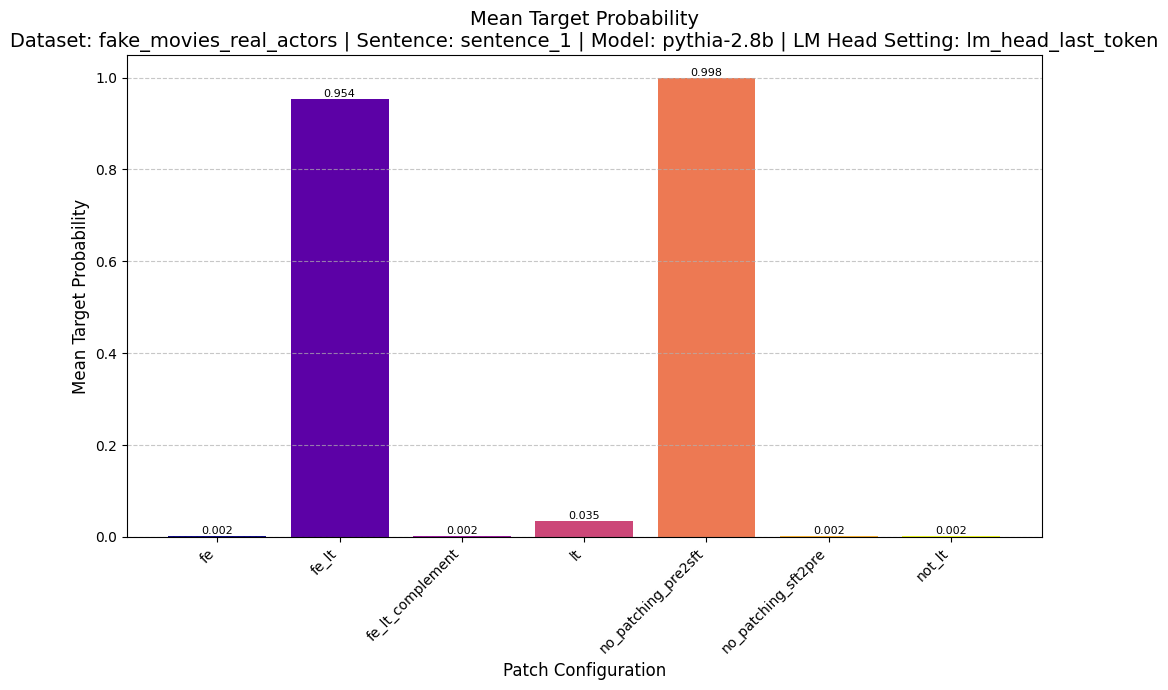

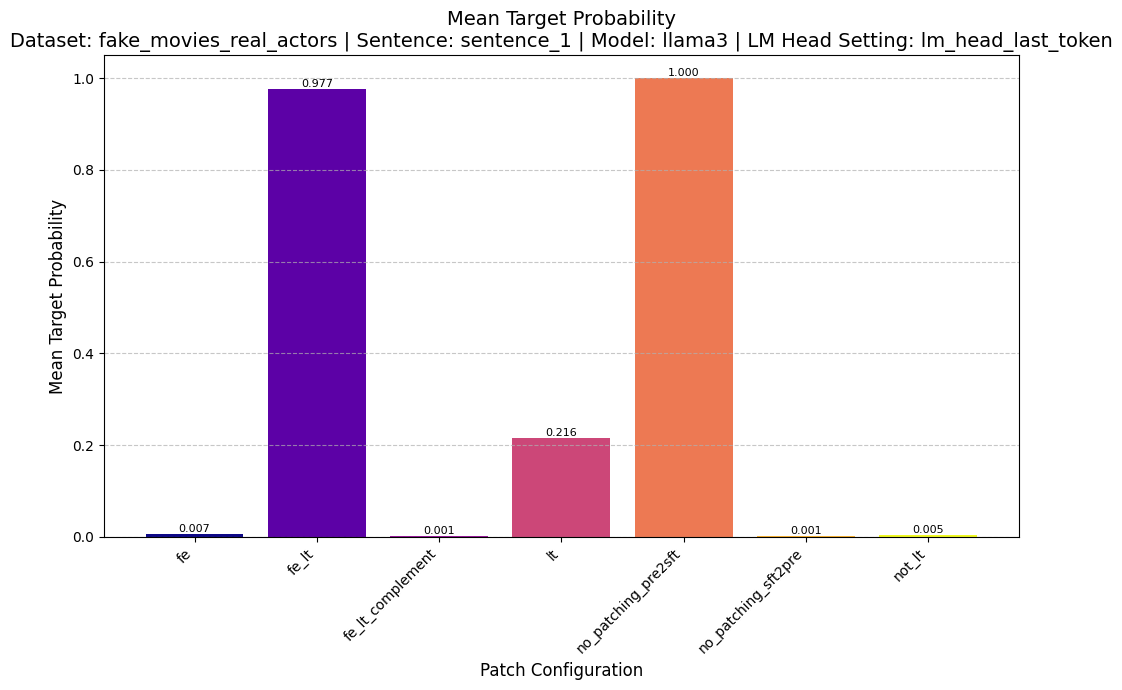

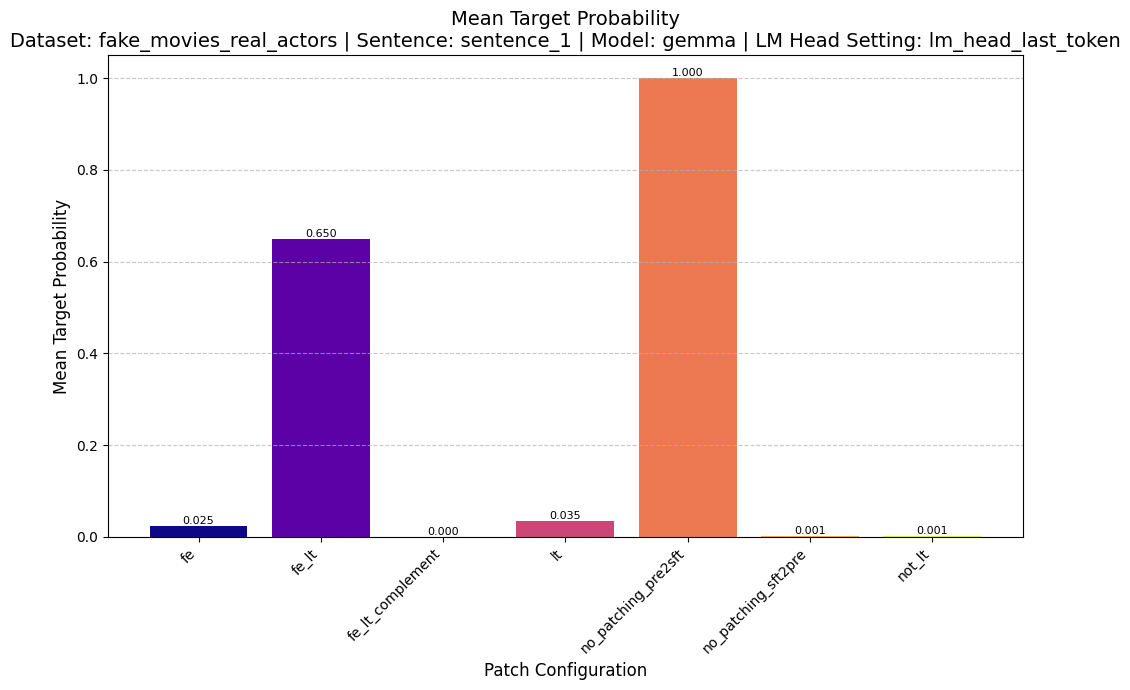

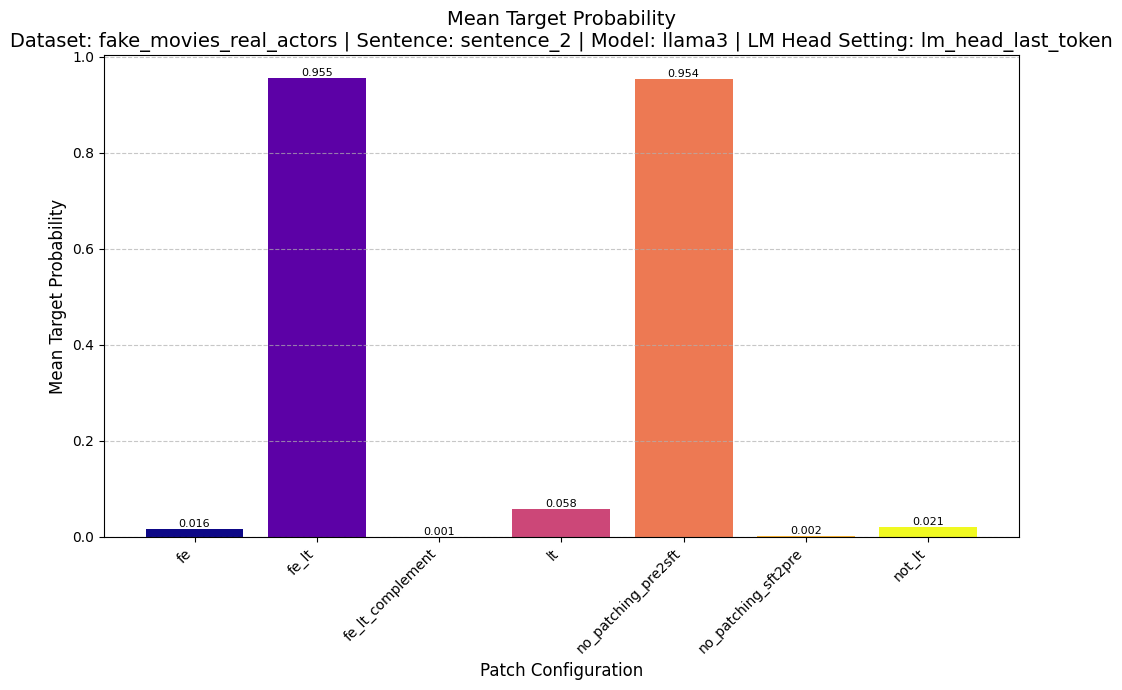

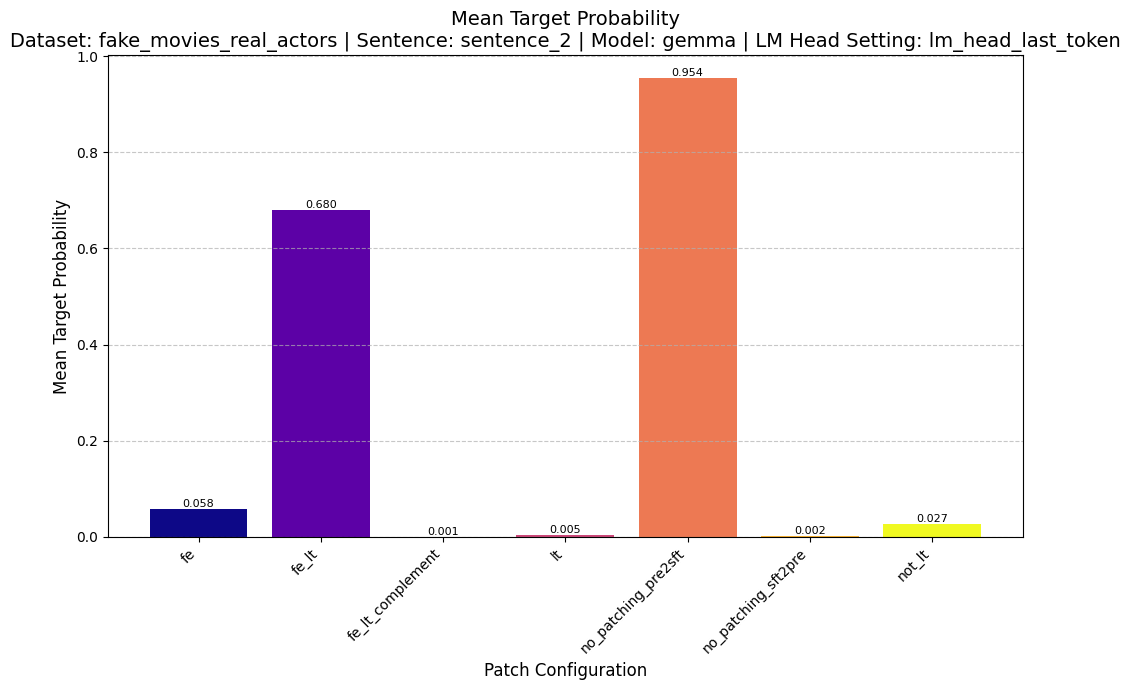

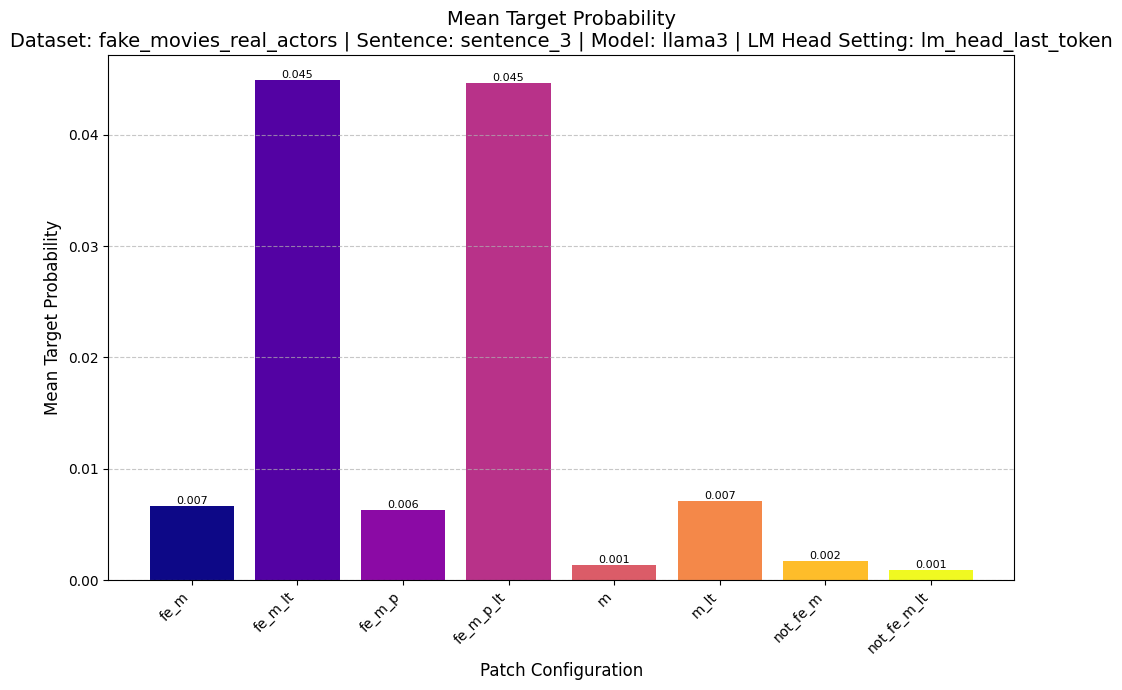

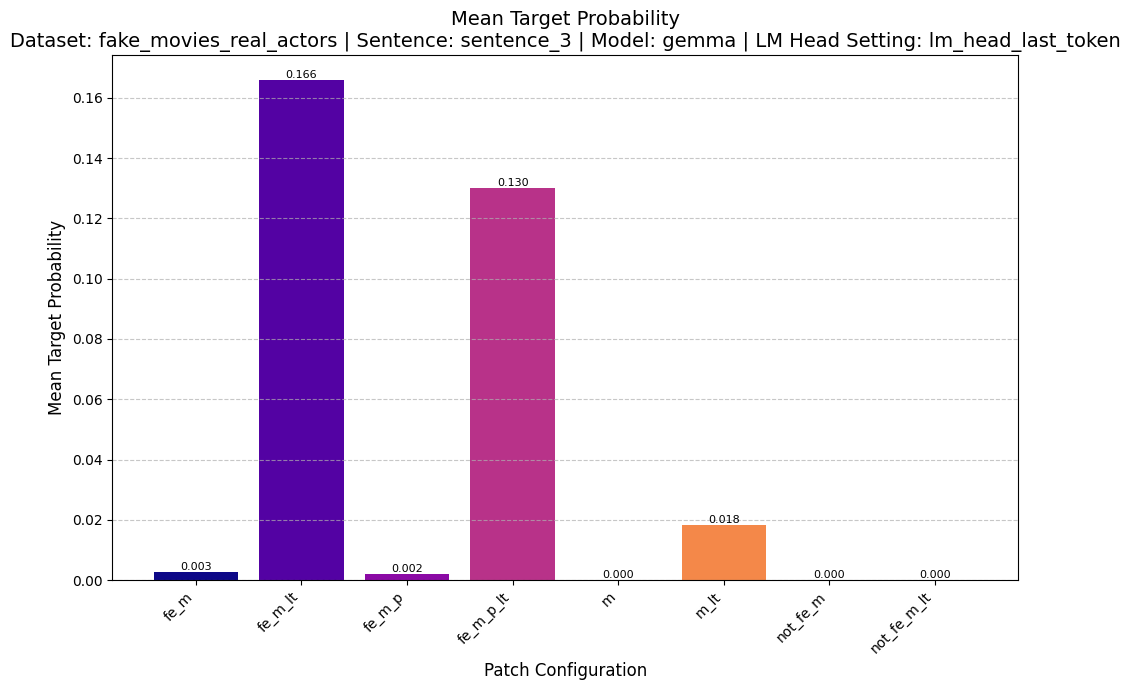

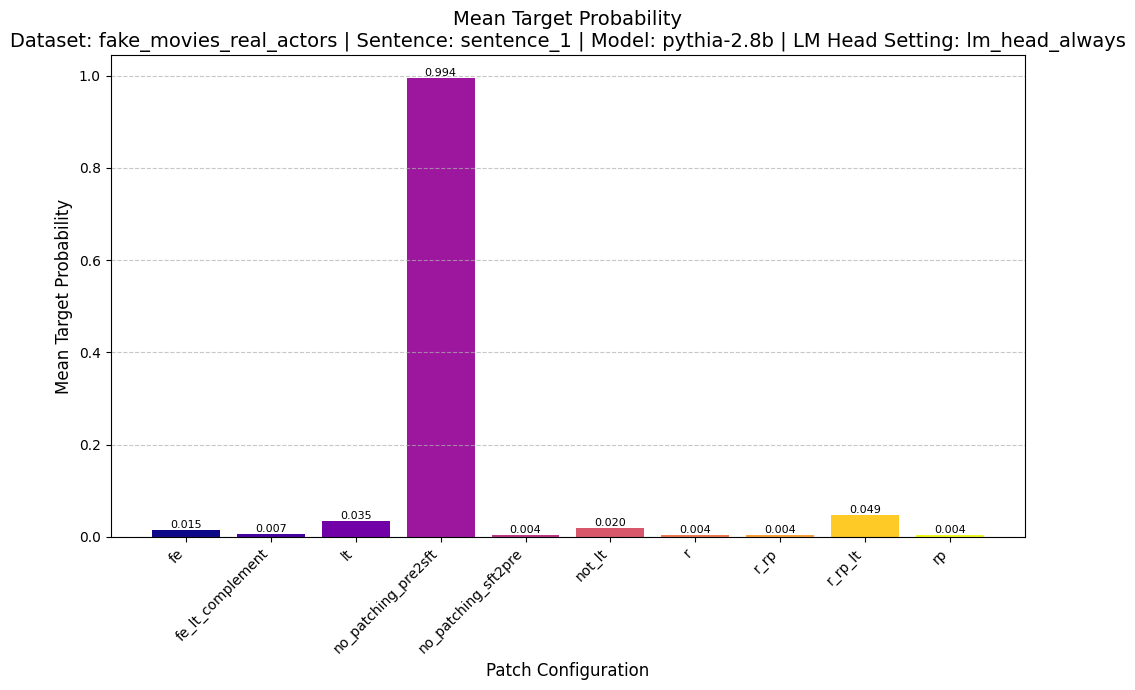

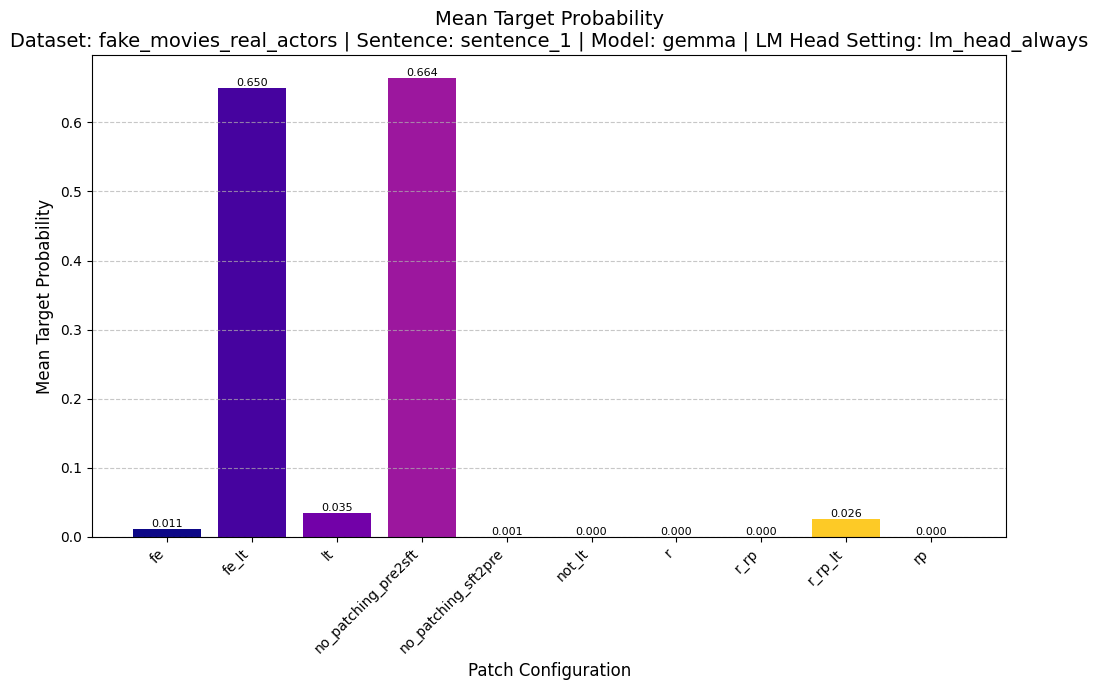

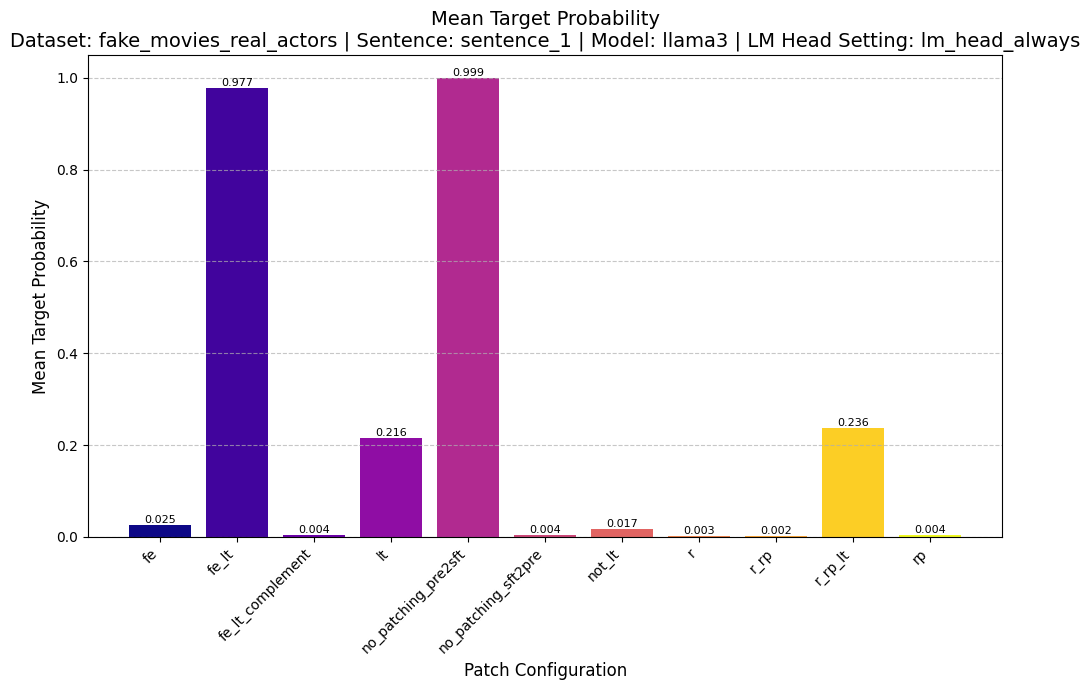

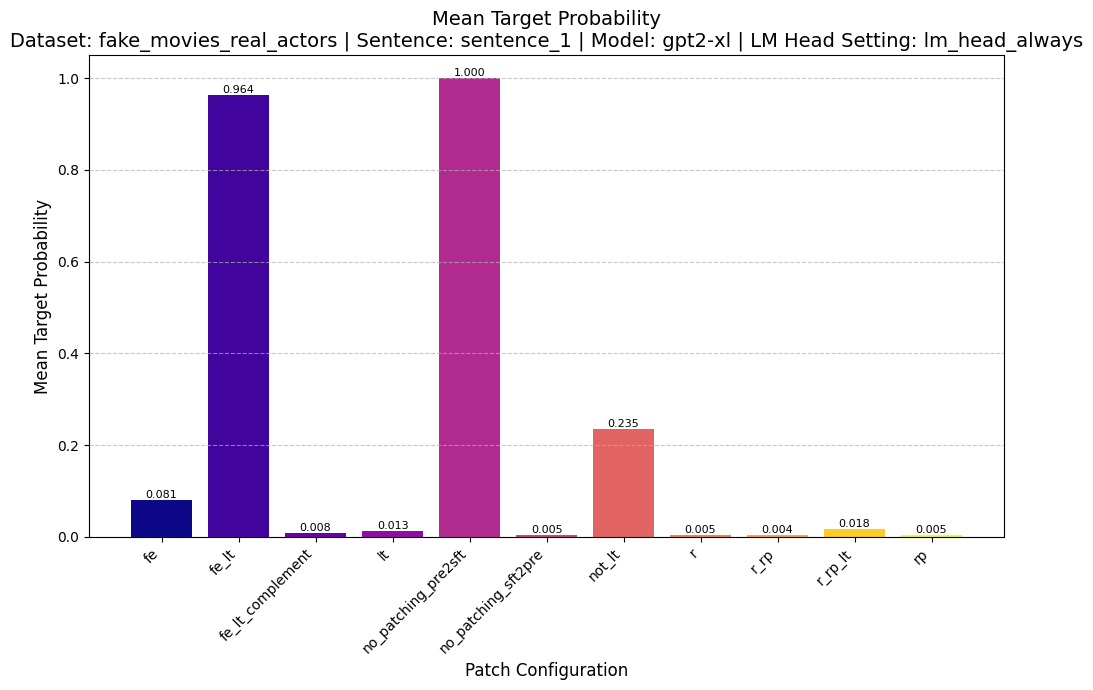

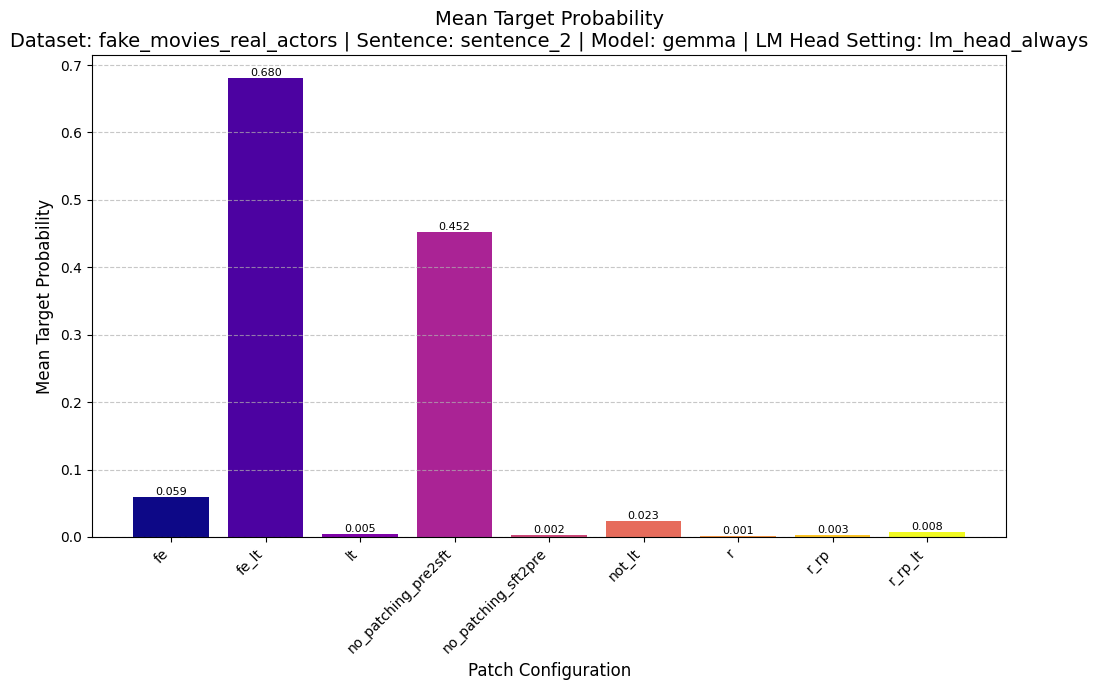

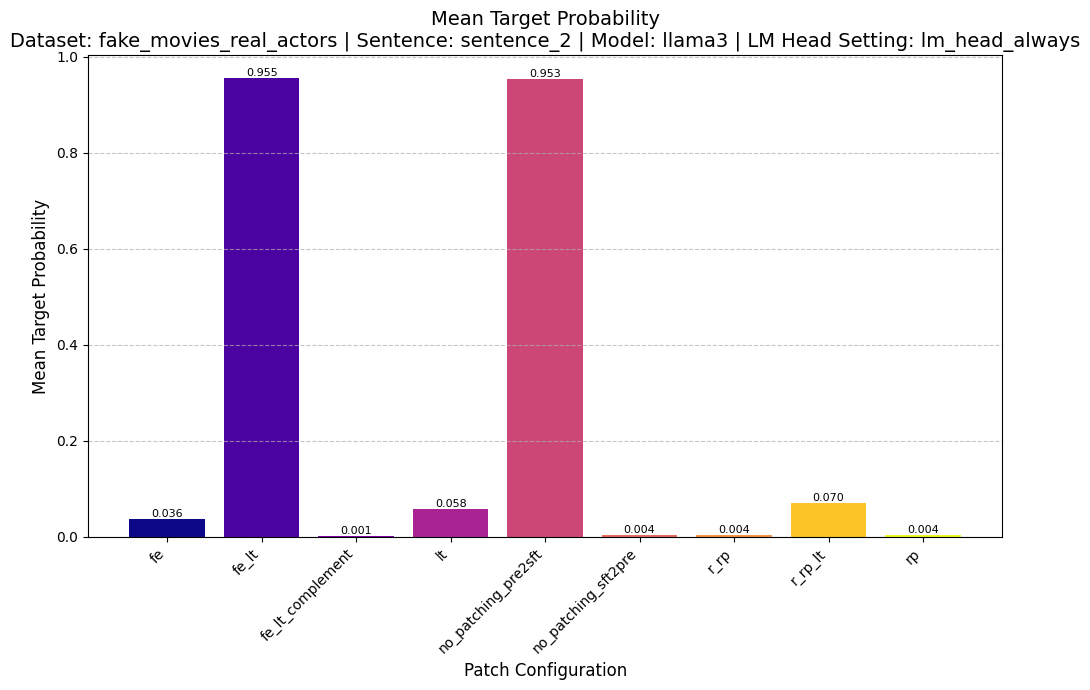

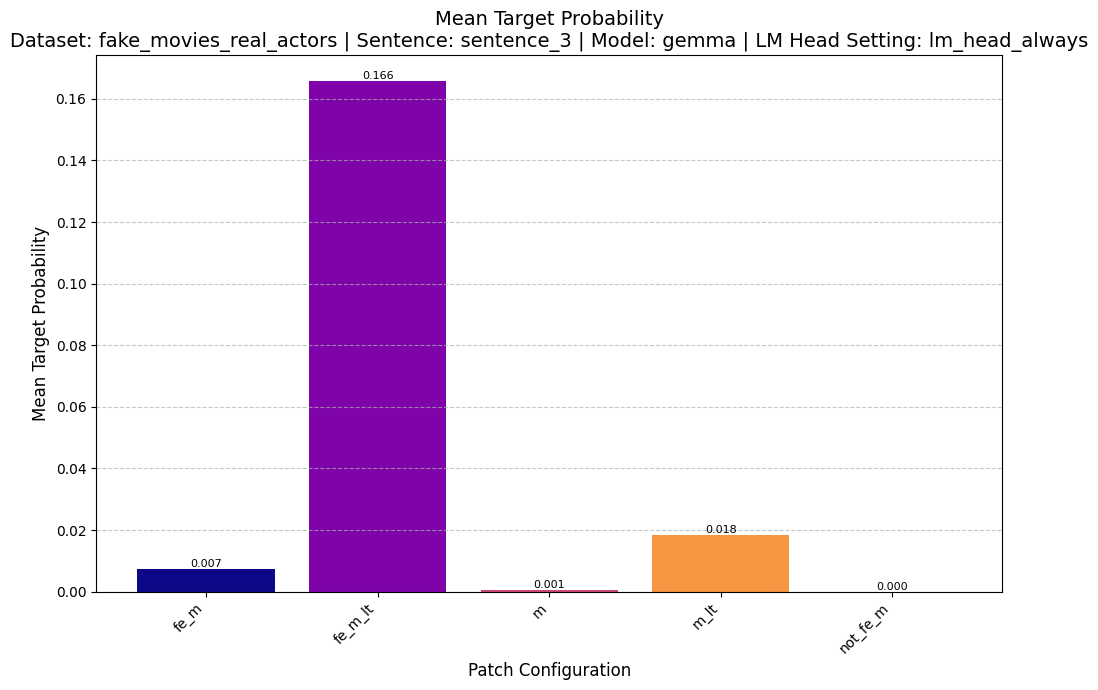

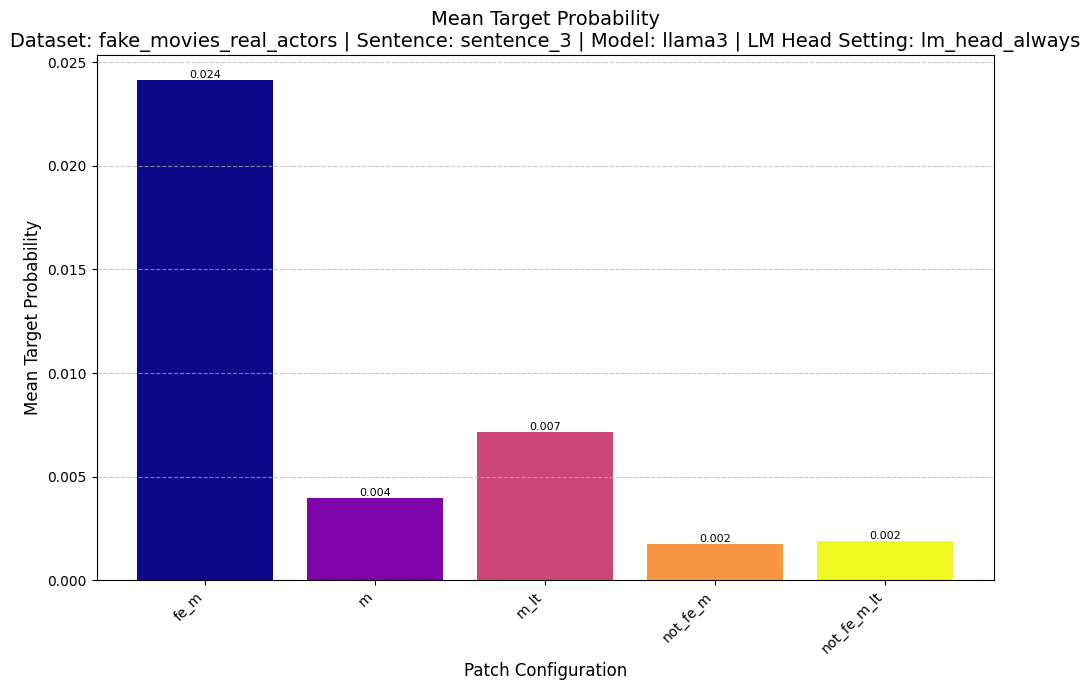

In [10]:
metric_key = "mean_target_prob"
plot_metric(organized_results, metric_key)